### ALGORITHMIC PROGRAMMING: ORDER ACCEPTANCE AND SCHEDULING PROBLEM 

### Students: Vivens Irakoze, Ioannis Villis

### Introduction

### 1. Input Data

- ***Read Input Data:***

In [1]:
import numpy as np
import time

file_names = ['OAS0.txt', 'OAS1.txt', 'OAS2.txt', 'OAS3.txt', 'OAS4.txt', 'OAS5.txt', 'OAS6.txt']

def readInput(fileName):
    """
    Read the input data from a file and return relevant arrays.
    """
    file0 = open(fileName, 'r')

    data = np.loadtxt(fileName)

    duration = data[0].astype(int) 
    profit = data[1].astype(int) 
    dueDate = data[2].astype(int) 
    deadline = data[3].astype(int)  
    tardCost = data[4] 
    numberOrders = len(duration) 

    setup = np.zeros((numberOrders, numberOrders)).astype(int) 
    index = 0
    while index < numberOrders:
        setup[index] = data[5 + index].astype(int)
        index += 1

    file0.close()

    return duration, profit, dueDate, deadline, tardCost, numberOrders, setup

### 2. Functions

In [2]:
from itertools import permutations
import matplotlib.pyplot as plt

'''1.Start Times Calculation'''
def cal(duration, setup, sequence):
    # Calculate start and finish times for a given sequence.
    num_orders = len(sequence)
    start_times = np.zeros(num_orders)
    finish_times = np.zeros(num_orders)

    # Initial order
    start_times[0] = 0
    finish_times[0] = duration[sequence[0]]

    # Compute times for subsequent orders
    for i in range(1, num_orders):
        prev_order = sequence[i - 1]
        current_order = sequence[i]
        start_times[i] = finish_times[i - 1] + setup[prev_order][current_order]
        finish_times[i] = start_times[i] + duration[current_order]

    return start_times, finish_times


'''2.Feasibility Check and Profit Calculation'''

def eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence):
    # Evaluate a given sequence for feasibility and objective value.
    num_orders = len(sequence)
    start_times = np.zeros(num_orders)
    finish_times = np.zeros(num_orders)
    infeasible = False

    start_times[0] = 0
    finish_times[0] = duration[sequence[0]]

    for i in range(1, num_orders):
        prev_order = sequence[i - 1]
        current_order = sequence[i]
        start_times[i] = finish_times[i - 1] + setup[prev_order][current_order]
        finish_times[i] = start_times[i] + duration[current_order]

    total_profit = 0
    total_tardiness_cost = 0

    for idx, order in enumerate(sequence):
        # Overlapping tasks
        if idx > 0 and start_times[idx] < finish_times[idx - 1]:
            infeasible = True
            return None 

        # Deadline exceeded
        if finish_times[idx] > deadline[order]:
            infeasible = True   
            return None 

        # Profit or tardiness calculation
        if finish_times[idx] <= dueDate[order]:
            total_profit += profit[order]
        else:
            tardiness = finish_times[idx] - dueDate[order]
            total_tardiness_cost += tardiness * tardCost[order]

    if infeasible:
        print("There is no feasible solution.")

    return total_profit - total_tardiness_cost

"""3.Visualization function"""

def visualize(duration, setup, deadline, scheduled_orders, heuristic_name):
    # Function to visualize the schedule using a Gantt chart for a specific heuristic.
    if not scheduled_orders:
        print(f"No scheduled orders to visualize for {heuristic_name}.")
        return

    num_orders = len(scheduled_orders)
    start_times = [0] * num_orders
    finish_times = [0] * num_orders

    for i, order in enumerate(scheduled_orders):
        if i == 0:
            start_times[i] = 0
        else:
            prev_order = scheduled_orders[i - 1]
            start_times[i] = finish_times[i - 1] + setup[prev_order][order]
        finish_times[i] = start_times[i] + duration[order]

    plt.figure(figsize=(12, 8))
    order_color = 'skyblue' 

    for i, order in enumerate(scheduled_orders):
        plt.barh(i, finish_times[i] - start_times[i], left=start_times[i], color=order_color)
        plt.text(start_times[i] + (finish_times[i] - start_times[i]) / 2, i,
                 f"Order {order + 1}", ha='center', va='center', fontsize=10, color='black')
        
        plt.vlines(deadline[order], i - 0.4, i + 0.4, color='red', linestyle='--', label='Deadline' if i == 0 else "")

    plt.yticks(range(num_orders), [f"Order {order + 1}" for order in scheduled_orders])
    plt.xlabel("Time")
    plt.ylabel("Orders")
    plt.title(f"Gantt Chart: {heuristic_name}")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

"""4.Print Function"""

def print_results(file_name, scheduled_orders, total_profit, elapsed_time, heuristic_name):

    scheduled_orders_ = [order + 1 for order in scheduled_orders]
    print(f"Results for {file_name} using {heuristic_name}:")
    print(f"Scheduled Orders: {scheduled_orders_}")
    print(f"Total Profit: {total_profit}")
    print(f"Run Time: {elapsed_time:.4f} seconds")
    print("-" * 50)

"""5.Run, Print and Visualize"""

def Run_and_visualize(file_name, heuristic_function, heuristic_name):

    start_time = time.time() 
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)
    scheduled_orders, total_profit = heuristic_function(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    end_time = time.time() 
    elapsed_time = end_time - start_time

    visualize(duration, setup, deadline, scheduled_orders, heuristic_name)

    print_results(file_name, scheduled_orders, total_profit, elapsed_time, heuristic_name)

### 3. Exact Solution Methods

#### **3.1 Brute Force**

- ***Code :***

In [3]:
class Brute_Force_Schedule:
    def __init__(self, duration, profit, dueDate, deadline, tardCost, setup, start_times):
        self.duration = duration
        self.profit = profit
        self.dueDate = dueDate
        self.deadline = deadline
        self.tardCost = tardCost
        self.start_times = start_times  # not really used, just to call eval
        self.setup = setup

    def enumerate_solutions(self):
        """Enumerate all possible solutions using Permutations."""
        best_profit = -float('inf')
        best_sequence = None
        best_finish_times = None

        num_orders = len(self.duration)
        all_solutions = []

        # Iterate through all possible sequences of orders
        for r in range(1, num_orders + 1):  # Include partial solutions with 1 to num_orders orders
            for seq_index, sequence in enumerate(permutations(range(num_orders), r)):
                result = eval(
                    self.duration,
                    self.profit,
                    self.dueDate,
                    self.deadline,
                    self.tardCost,
                    self.setup,
                    self.start_times,
                    sequence,
                )
                if result is not None:
                    all_solutions.append((sequence, result))

                    # Update the best solution if needed
                    if result > best_profit:
                        best_profit = result
                        best_sequence = tuple(order + 1 for order in sequence)  # Convert sequence to 1-based
                        _, best_finish_times = cal(self.duration, self.setup, sequence)

        return best_profit, best_sequence, best_finish_times

- ***Visualization :***

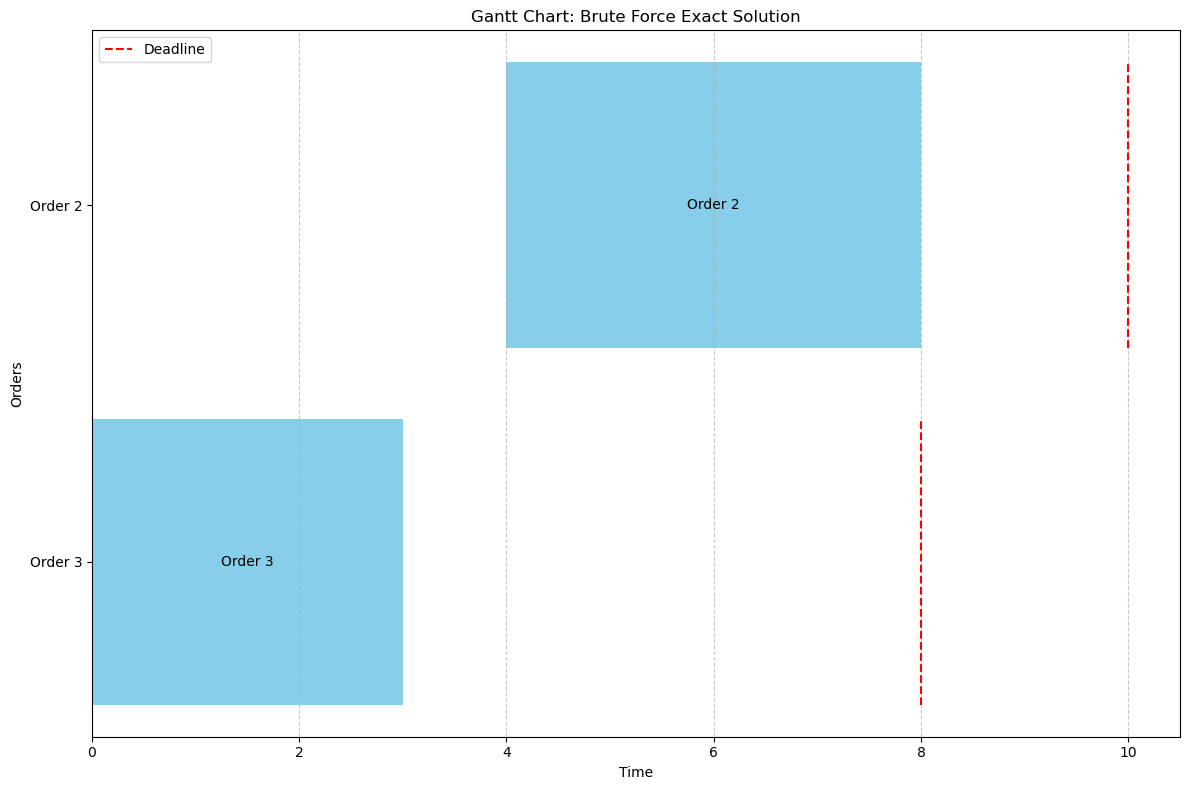

Results for OAS0.txt using Brute Force:
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0030 seconds
--------------------------------------------------


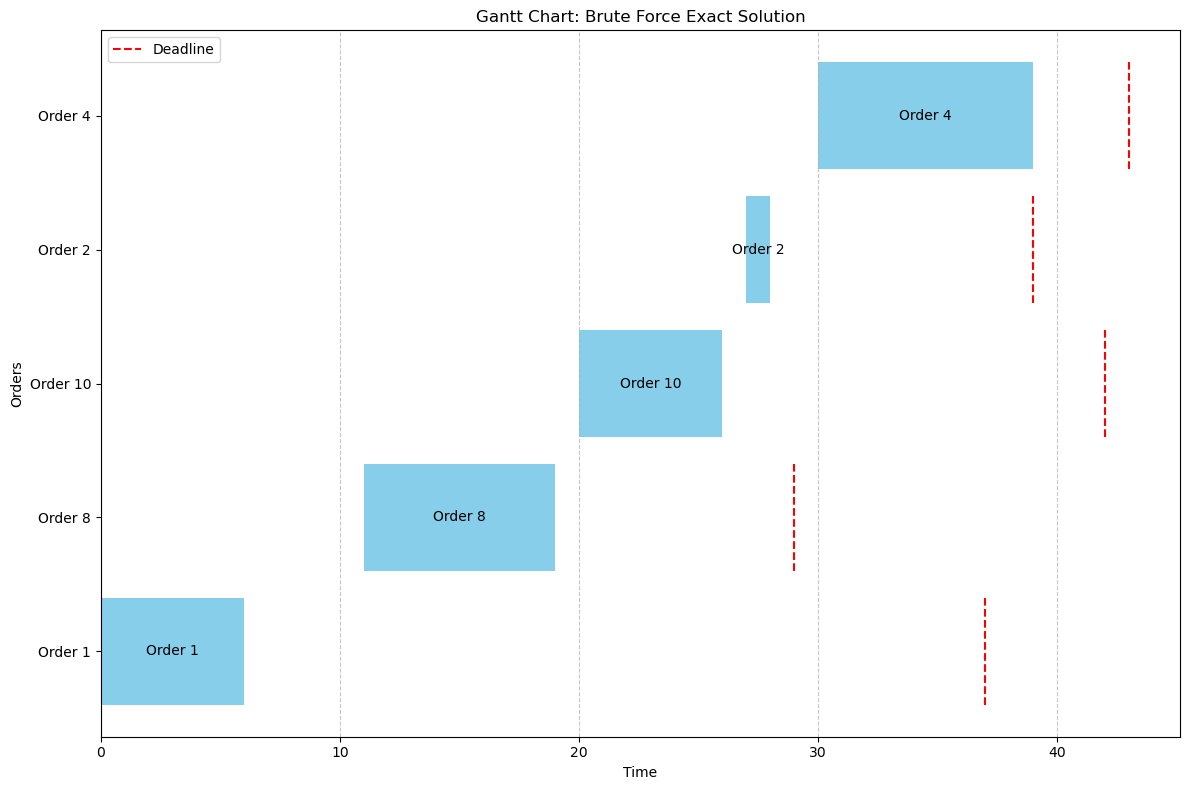

Results for OAS1.txt using Brute Force:
Scheduled Orders: [1, 8, 10, 2, 4]
Total Profit: 382
Run Time: 147.7251 seconds
--------------------------------------------------


In [ ]:
def Run_and_visualize_brute_force(file_name):
    start_time = time.time()

    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)

    scheduler = Brute_Force_Schedule(duration, profit, dueDate, deadline, tardCost, setup, start_times=None)
    best_profit, best_sequence, _ = scheduler.enumerate_solutions()

    end_time = time.time()
    elapsed_time = end_time - start_time

    if best_sequence is not None:
        visualize(duration, setup, deadline, [order - 1 for order in best_sequence], "Brute Force Exact Solution")
    else:
        print(f"No feasible solution found for {file_name}.")
        return

    print_results(file_name, [order - 1 for order in best_sequence], best_profit, elapsed_time, "Brute Force")

'''Only the first two files are relevant'''
selected_files = file_names[:2]

for file_name in selected_files:
    Run_and_visualize_brute_force(file_name)

#### **3.2 MIP**

- ***Code :***

In [5]:
def MIP(file_names):
    import gurobipy as gp
    from gurobipy import GRB
    import numpy as np

    # Read input data
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_names)

    # Adding setup times and durations for the dummy start (0) and end (n+1) nodes
    setup_expanded = np.zeros((numberOrders + 2, numberOrders + 2)).astype(int)
    duration_expanded = np.zeros(numberOrders + 2).astype(int)

    setup_expanded[1:numberOrders + 1, 1:numberOrders + 1] = setup
    duration_expanded[1:numberOrders + 1] = duration

    # Create the Gurobi model
    model = gp.Model("MIP_Scheduling")

    # Decision variables
    x = model.addVars(numberOrders + 2, numberOrders + 2, vtype=GRB.BINARY, name="x")  # Does order i precede order j
    y = model.addVars(numberOrders + 2, vtype=GRB.BINARY, name="y")                    # Is order i scheduled?
    f = model.addVars(numberOrders + 2, vtype=GRB.CONTINUOUS, name="f")                # Finish times
    T = model.addVars(numberOrders + 2, vtype=GRB.CONTINUOUS, name="T")                # Tardiness

    # Large constant for big-M constraints
    M = 1000

    # Objective Function
    model.setObjective(
        gp.quicksum(profit[i - 1] * y[i] for i in range(1, numberOrders + 1)) -
        gp.quicksum(tardCost[i - 1] * T[i] for i in range(1, numberOrders + 1)),
        GRB.MAXIMIZE
    )

    # Constraints
    for i in range(numberOrders + 1):  # including dummy start node
        model.addConstr(
            gp.quicksum(x[i, j] for j in range(1, numberOrders + 2) if i != j) == y[i],
            name=f"successor_{i}"
        )
    for i in range(numberOrders + 2):
        model.addConstr(x[i, i] == 0, name=f"no_self_precedence_{i}")
    for i in range(1, numberOrders + 2):  # including dummy end node
        model.addConstr(
            gp.quicksum(x[j, i] for j in range(numberOrders + 1) if i != j) == y[i],
            name=f"predecessor_{i}"
        )
    for i in range(numberOrders + 1):
        for j in range(1, numberOrders + 2):
            if i != j:
                model.addConstr(
                    f[i] + (setup_expanded[i, j] + duration_expanded[j]) * x[i, j] - M * (1 - x[i, j]) <= f[j],
                    name=f"seq_{i}_{j}"
                )
    for i in range(1, numberOrders + 1):
        model.addConstr(f[i] <= deadline[i - 1] * y[i], name=f"deadline_{i}")
    for i in range(1, numberOrders + 1):
        model.addConstr(T[i] >= f[i] - dueDate[i - 1] - M * (1 - y[i]), name=f"tardiness_{i}")
        model.addConstr(T[i] >= 0, name=f"tard_0_{i}")
        model.addConstr(T[i] <= M * y[i], name=f"tard_limit_{i}")

    # Optimization Parameters
    model.setParam('TimeLimit', 900)  # Limit to 15 minutes
    model.setParam('MIPGap', 0.05)    # 5% gap

    # Solve the model
    model.optimize()

    # Extract and print results
    if model.status == GRB.OPTIMAL:
        print("Optimal solution found.")
        print("Profit (Objective Value): {:.2f}".format(model.objVal))
        print("\nScheduled Orders:")
        for i in range(1, numberOrders + 1):  # Excluding dummy start and end nodes
            if y[i].x > 0.5:
                print(f"  Order {i}: Finish Time = {f[i].x:.2f}, Tardiness = {T[i].x:.2f}")
    else:
        print("No optimal solution found.")

- ***Visualize :***

In [6]:
def Run_mip(file_names):
    selected_files = file_names[:2]  # Selecting the first two files
    for file_name in selected_files:
        MIP(file_name)

Run_mip(file_names)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2560044
Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Set parameter TimeLimit to value 900
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  900
MIPGap  0.05

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 38 rows, 40 columns and 102 nonzeros
Model fingerprint: 0xc1345b4b
Variable types: 10 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 

### 4 Greedy construction heuristics

#### **4.1 Insertion Heuristic**

- ***Code :***

In [7]:
def insertion(duration, profit, dueDate, deadline, tardCost, numberOrders, setup):
    """
    Greedy insertion heuristic for scheduling.
    Always adds the order that maximizes profit.
    """
    remaining_orders = list(range(numberOrders))  
    scheduled_orders = []  
    total_profit = 0  

    while remaining_orders:
        best_order = None
        best_profit = total_profit

        # Evaluate each remaining order for sequential addition
        for order in remaining_orders:
            # Create a tentative schedule by appending an order.
            tentative_schedule = scheduled_orders + [order]

            # Calculate the profit of the tentative schedule
            start_times, _ = cal(duration, setup, tentative_schedule)
            current_profit = eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, tentative_schedule)

            # Update the best order if it improves the profit
            if current_profit is not None and current_profit > best_profit:
                best_order = order
                best_profit = current_profit

        # Add the best order found to the schedule
        if best_order is not None:
            scheduled_orders.append(best_order)
            total_profit = best_profit
            remaining_orders.remove(best_order)
        else:
            # If no feasible order can be added, stop
            break

    return scheduled_orders, total_profit

- ***Visualization :***

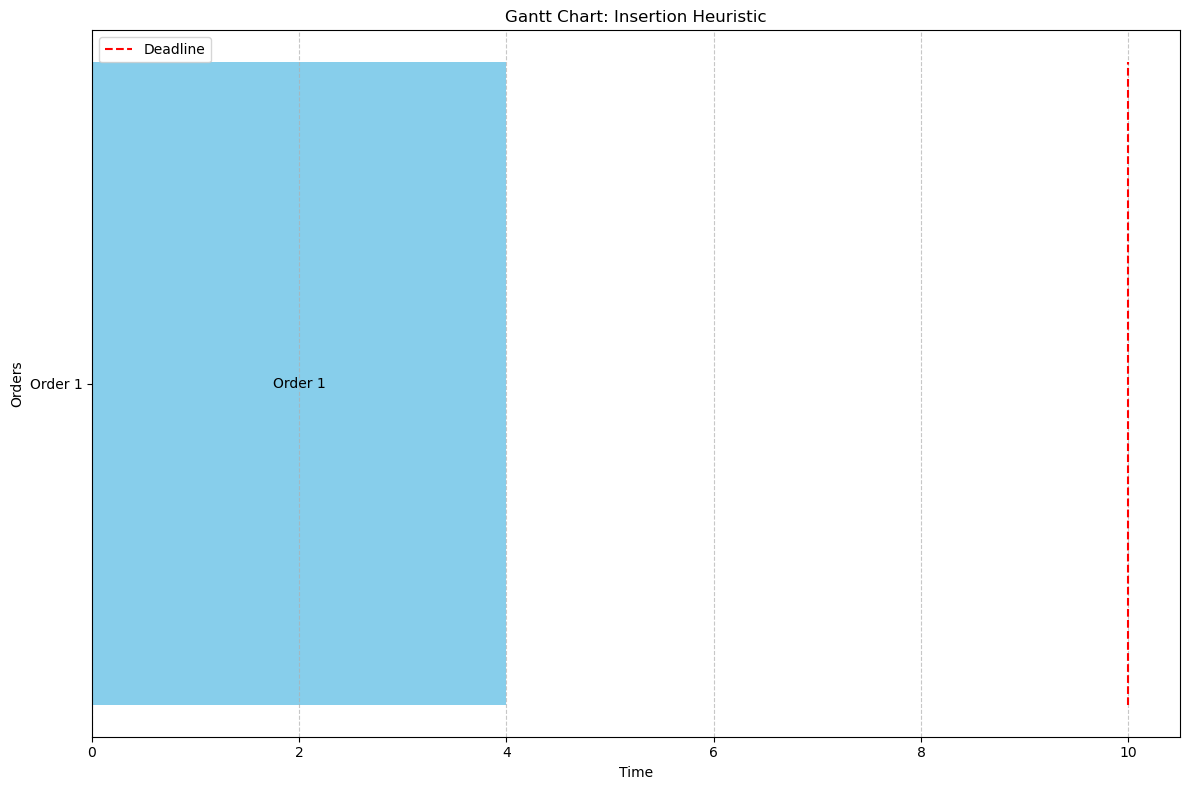

Results for OAS0.txt using Insertion Heuristic:
Scheduled Orders: [1]
Total Profit: 10
Run Time: 0.0010 seconds
--------------------------------------------------


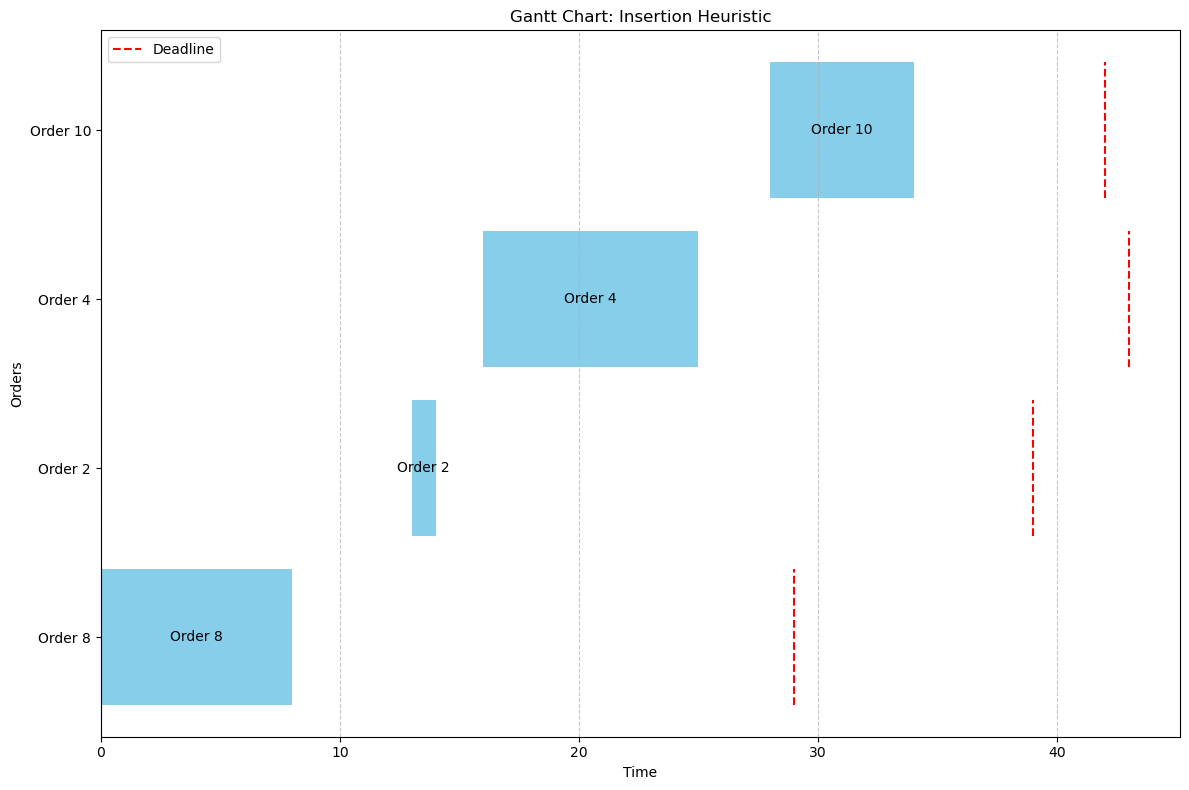

Results for OAS1.txt using Insertion Heuristic:
Scheduled Orders: [8, 2, 4, 10]
Total Profit: 304
Run Time: 0.0020 seconds
--------------------------------------------------


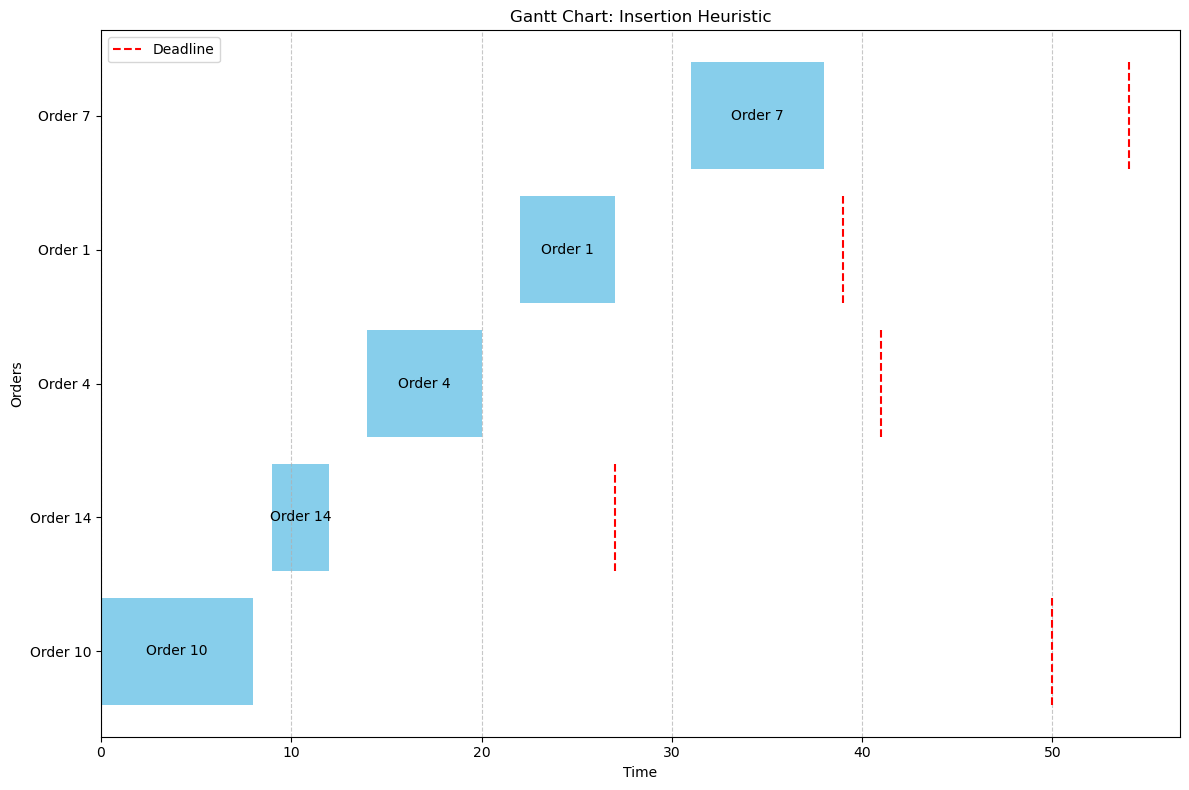

Results for OAS2.txt using Insertion Heuristic:
Scheduled Orders: [10, 14, 4, 1, 7]
Total Profit: 377
Run Time: 0.0030 seconds
--------------------------------------------------


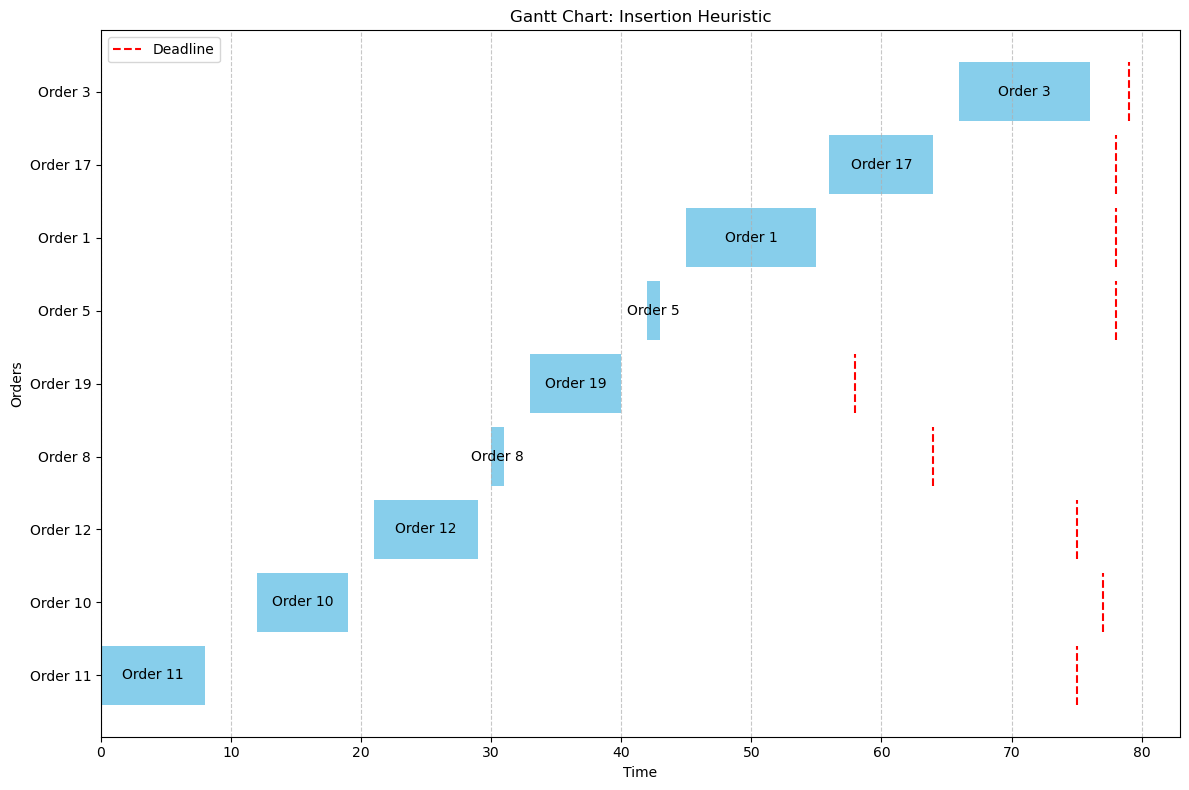

Results for OAS3.txt using Insertion Heuristic:
Scheduled Orders: [11, 10, 12, 8, 19, 5, 1, 17, 3]
Total Profit: 634
Run Time: 0.0279 seconds
--------------------------------------------------


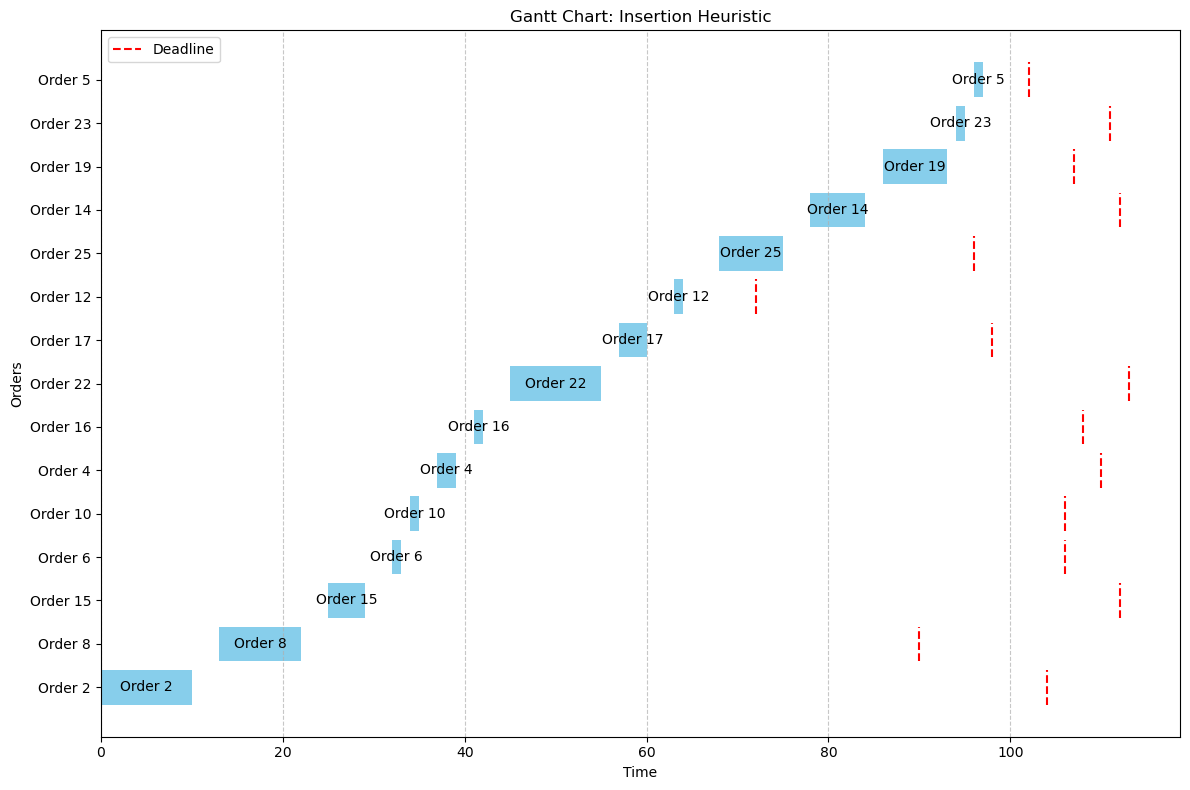

Results for OAS4.txt using Insertion Heuristic:
Scheduled Orders: [2, 8, 15, 6, 10, 4, 16, 22, 17, 12, 25, 14, 19, 23, 5]
Total Profit: 762
Run Time: 0.0339 seconds
--------------------------------------------------


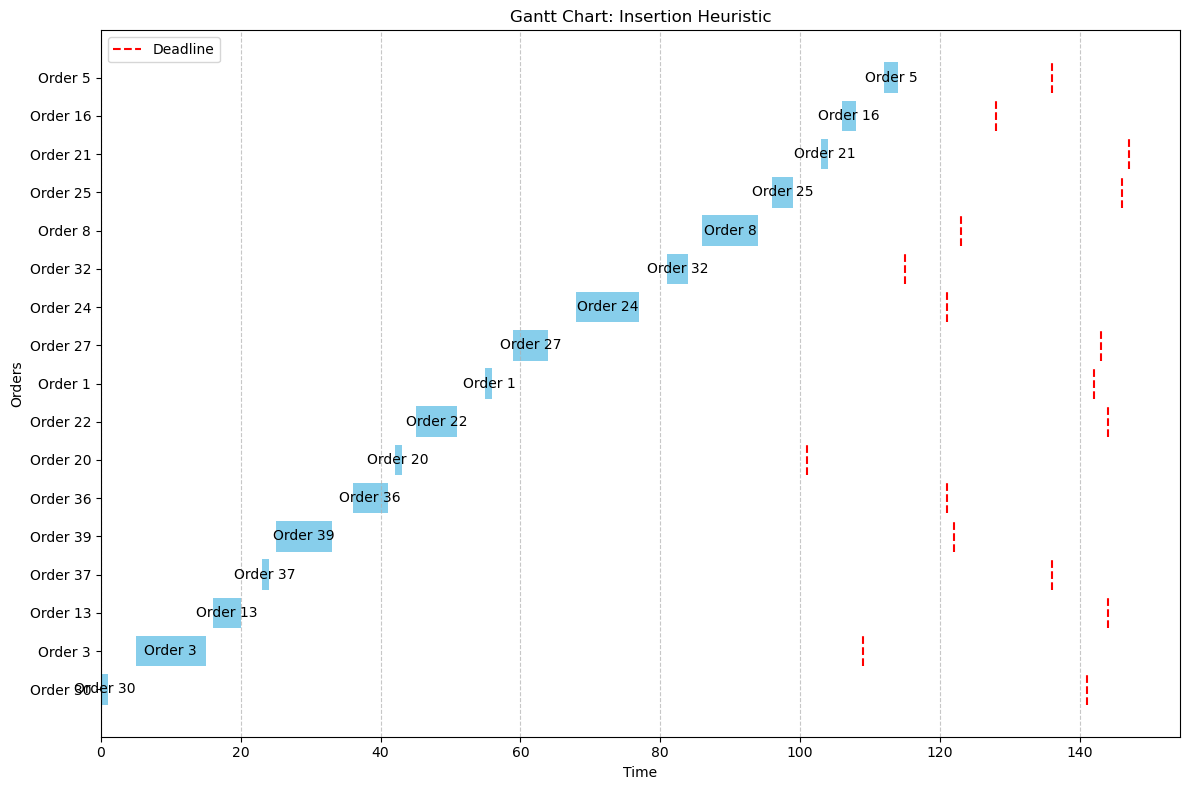

Results for OAS5.txt using Insertion Heuristic:
Scheduled Orders: [30, 3, 13, 37, 39, 36, 20, 22, 1, 27, 24, 32, 8, 25, 21, 16, 5]
Total Profit: 1079
Run Time: 0.0447 seconds
--------------------------------------------------


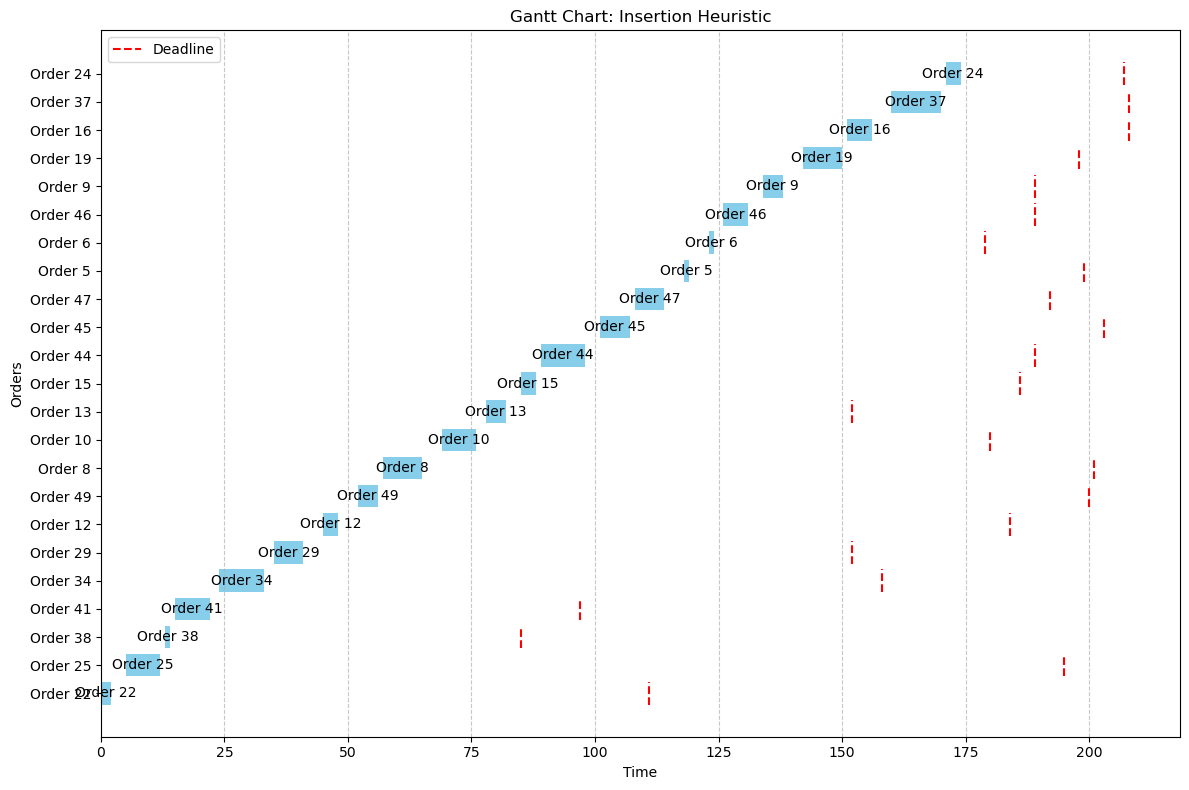

Results for OAS6.txt using Insertion Heuristic:
Scheduled Orders: [22, 25, 38, 41, 34, 29, 12, 49, 8, 10, 13, 15, 44, 45, 47, 5, 6, 46, 9, 19, 16, 37, 24]
Total Profit: 1560
Run Time: 0.0527 seconds
--------------------------------------------------


In [8]:
for file_name in file_names:
    Run_and_visualize(file_name, insertion, "Insertion Heuristic")

#### **4.2 Savings Heuristic**

- ***code :***

In [9]:
import random

def savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup):
    """
    Savings heuristic: Starts from a solution with all orders (infeasible) and iteratively remove
    the order with the lowest profit until the solution is feasible, ensuring no overlaps, deadlines are met,
    and total duration does not exceed desired duration.
    """
    # Start with all orders in the solution (neglect infeasibility) and shuffle the list
    scheduled_orders = list(range(numberOrders))
    random.shuffle(scheduled_orders)
    
    # Calculate initial start and finish times
    start_times, finish_times = cal(duration, setup, scheduled_orders)
    total_duration = finish_times[-1] if finish_times.size > 0 else 0  # Total duration based on the last finish time
    
    # Check if the initial schedule is feasible
    if savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration):
        total_profit = sum(profit[o] for o in scheduled_orders)  # Total profit of all scheduled orders
        return scheduled_orders, total_profit

    while not savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration) and scheduled_orders:

        min_profit_order = min(scheduled_orders, key=lambda o: profit[o])
        
        scheduled_orders.remove(min_profit_order)
        
        start_times, finish_times = cal(duration, setup, scheduled_orders)
        total_duration = finish_times[-1] if finish_times.size > 0 else 0

    total_profit = sum(profit[o] for o in scheduled_orders)

    return scheduled_orders, total_profit


def savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration):
    """
    Checks if the solution is feasible based on the provided conditions:
    1. Tasks must not overlap.
    2. No task can exceed its deadline.
    3. Total duration must not exceed max_duration.
    """
    for idx, order in enumerate(scheduled_orders):
        # Overlapping tasks
        if idx > 0 and start_times[idx] < finish_times[idx - 1]:
            return False 
        
        # Deadline exceeded
        if finish_times[idx] > deadline[order]:
            return False  
    return True 

- ***Visualize :***

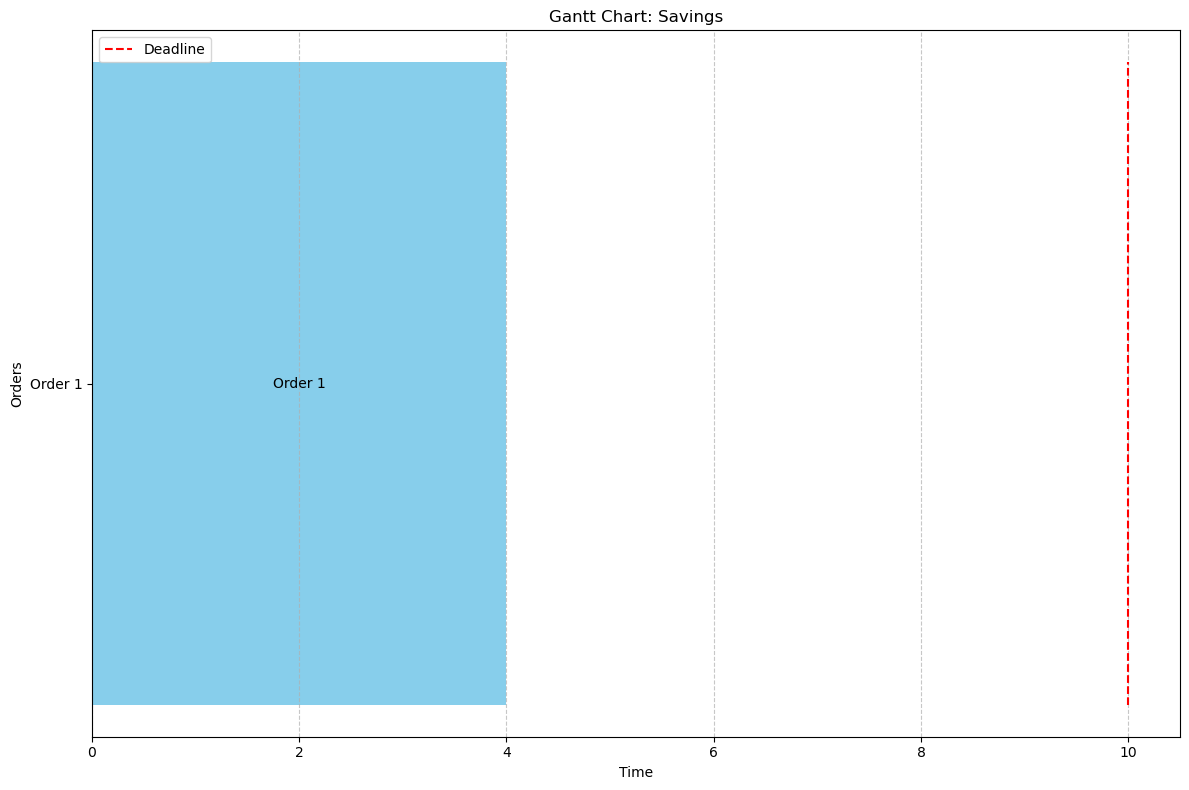

Results for OAS0.txt using Savings:
Scheduled Orders: [1]
Total Profit: 10
Run Time: 0.0010 seconds
--------------------------------------------------


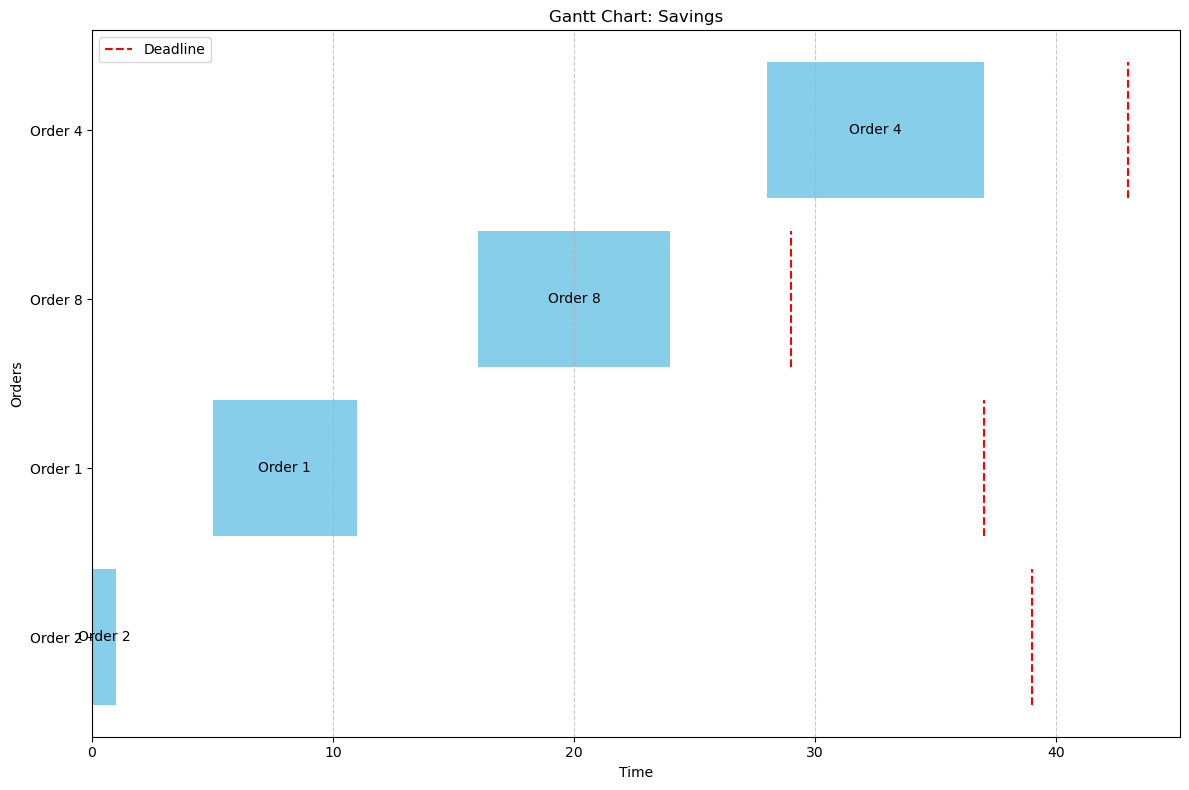

Results for OAS1.txt using Savings:
Scheduled Orders: [2, 1, 8, 4]
Total Profit: 322
Run Time: 0.0020 seconds
--------------------------------------------------


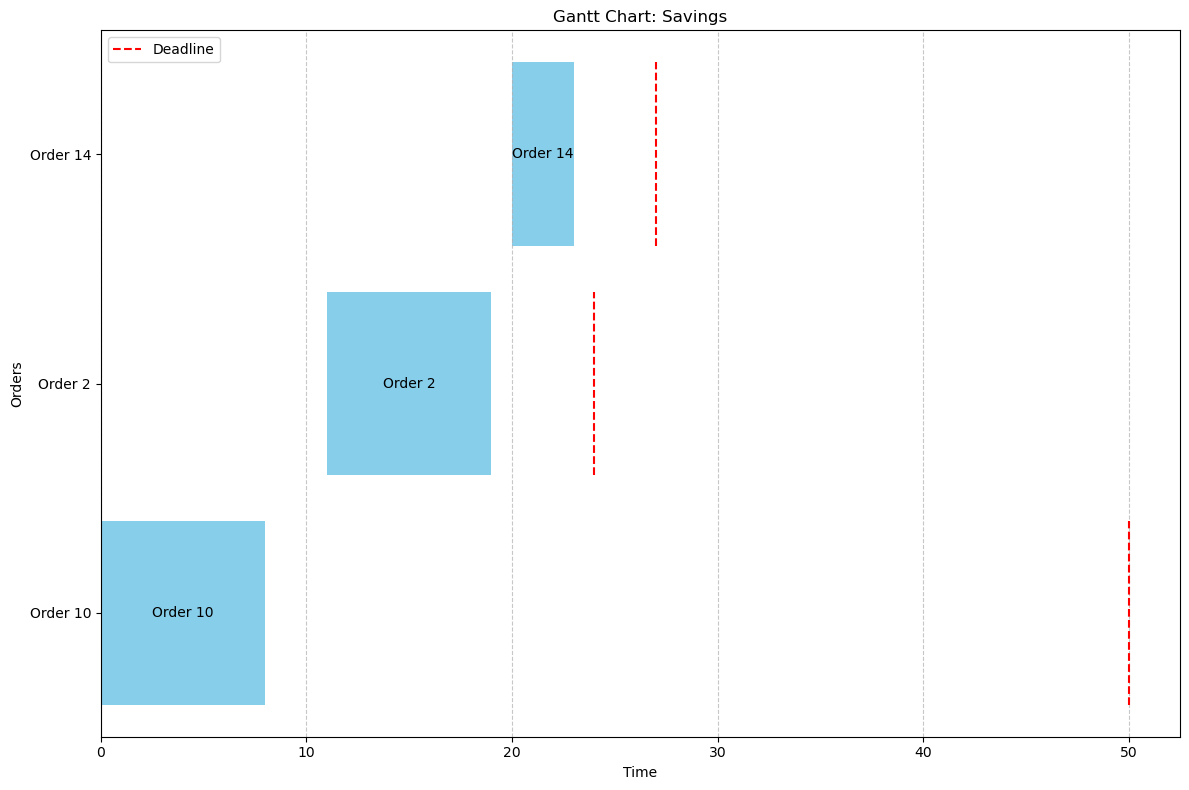

Results for OAS2.txt using Savings:
Scheduled Orders: [10, 2, 14]
Total Profit: 264
Run Time: 0.0020 seconds
--------------------------------------------------


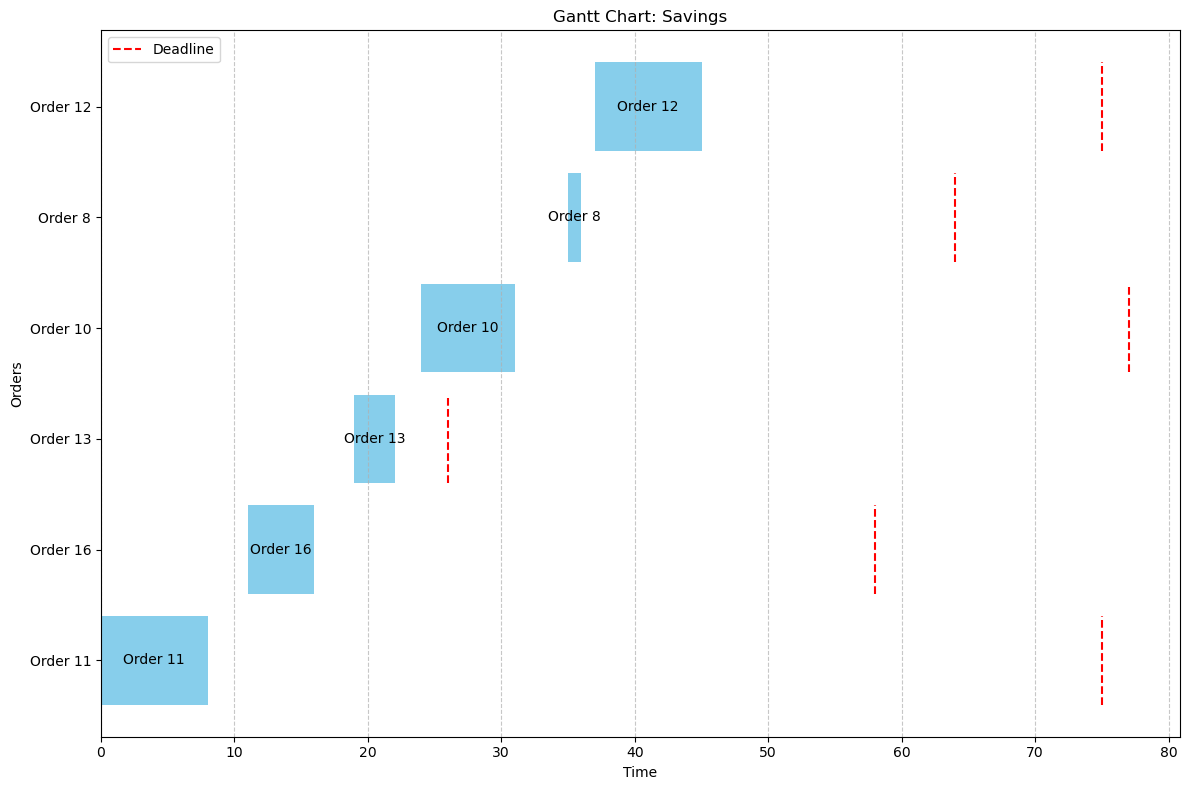

Results for OAS3.txt using Savings:
Scheduled Orders: [11, 16, 13, 10, 8, 12]
Total Profit: 529
Run Time: 0.0020 seconds
--------------------------------------------------


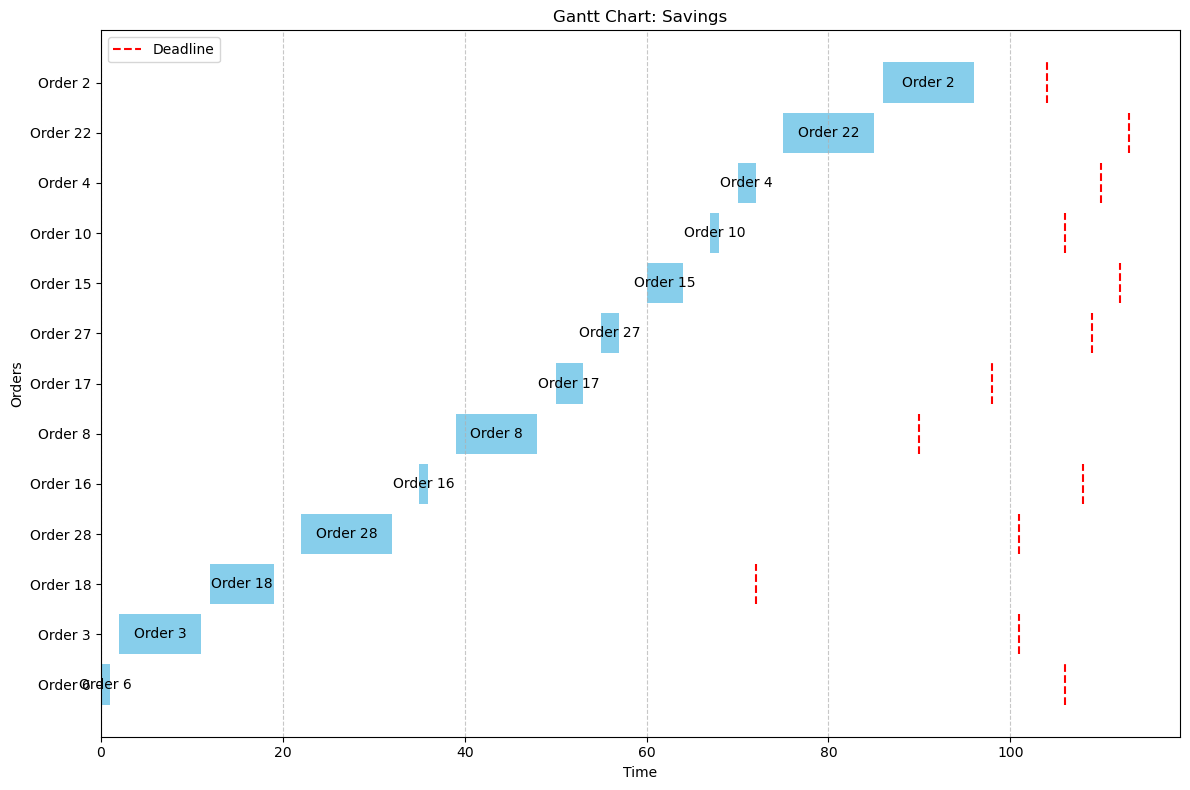

Results for OAS4.txt using Savings:
Scheduled Orders: [6, 3, 18, 28, 16, 8, 17, 27, 15, 10, 4, 22, 2]
Total Profit: 837
Run Time: 0.0020 seconds
--------------------------------------------------


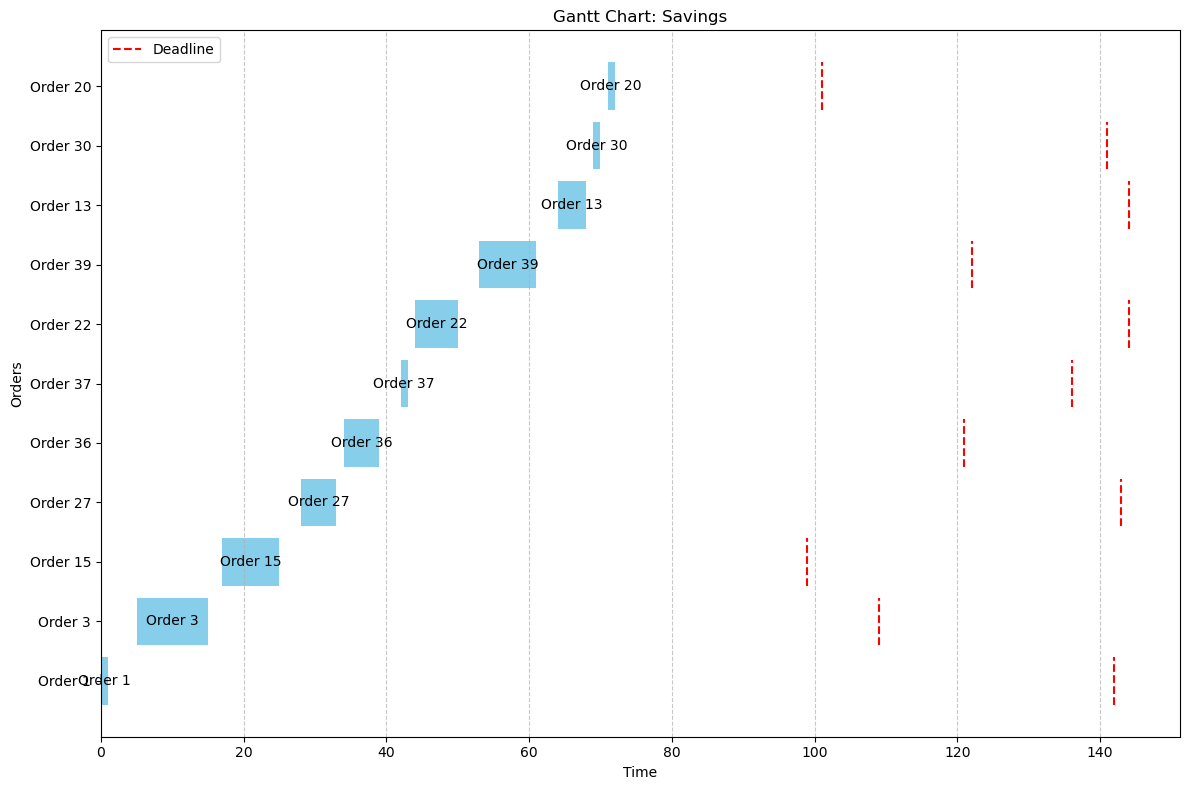

Results for OAS5.txt using Savings:
Scheduled Orders: [1, 3, 15, 27, 36, 37, 22, 39, 13, 30, 20]
Total Profit: 941
Run Time: 0.0030 seconds
--------------------------------------------------


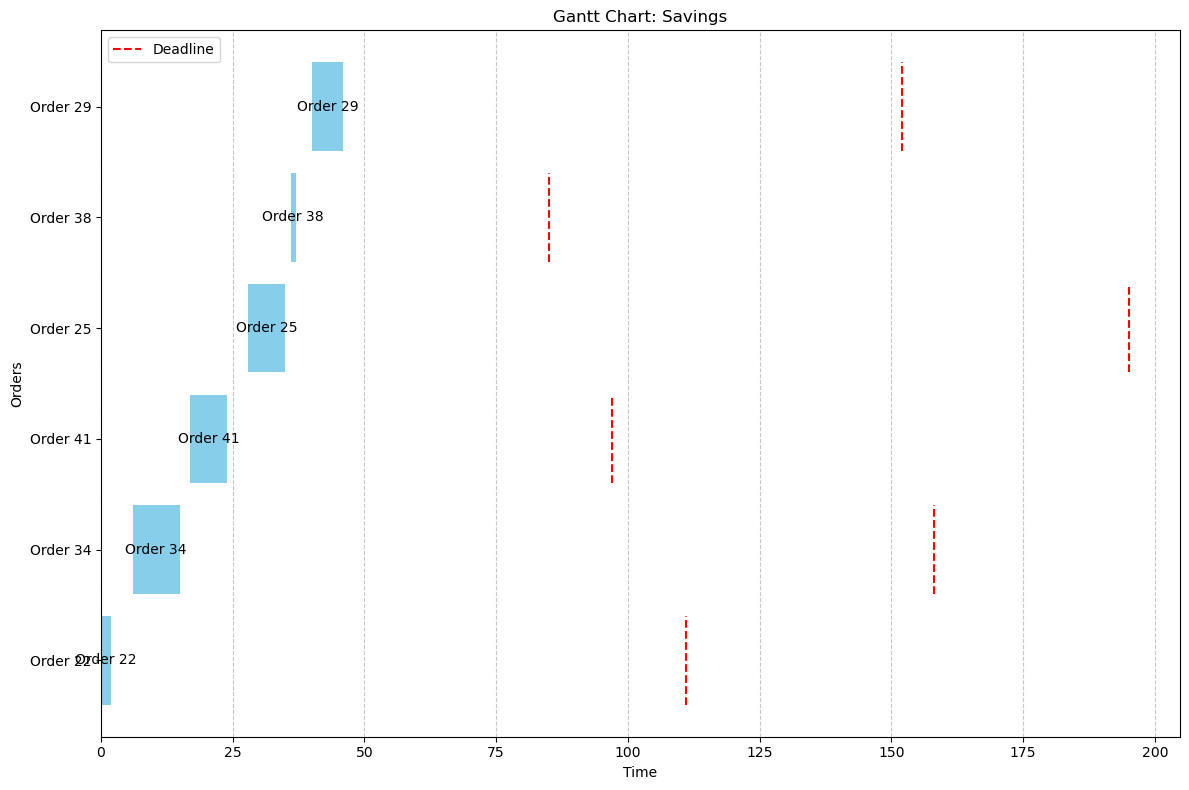

Results for OAS6.txt using Savings:
Scheduled Orders: [22, 34, 41, 25, 38, 29]
Total Profit: 566
Run Time: 0.0040 seconds
--------------------------------------------------


In [10]:
for file_name in file_names:
    Run_and_visualize(file_name, savings, "Savings")

#### **4.3 Construction Heuristics:**

In [11]:
def construct(duration, profit, dueDate, deadline, tardCost, numberOrders, setup):
    """
    Construct Heuristic for Scheduling.
    Dynamically selects orders to maximize profitability while checking feasibility.
    """
    numberOrders = len(duration)
    remaining_orders = list(range(numberOrders))
    schedule = []
    total_duration = 0
    total_profit = 0

    def score(order, prev_order=None):
        """
        Calculate a score for an order based on profitability, setup time, and tardiness penalties.
        """
        if prev_order is None:
            # First order: score based only on profit and duration
            return profit[order] / duration[order]
        else:
            # Subsequent orders: consider setup time and tardiness penalties
            setup_time = setup[prev_order][order]
            tardiness_penalty = (
                tardCost[order] * max(0, total_duration + setup_time + duration[order] - dueDate[order])
            )
            return profit[order] / (duration[order] + setup_time) - tardiness_penalty

    def construct_feasible(sequence):
        """
        Check the feasibility of the current sequence using `cal()`:
        - No overlapping tasks.
        - No deadlines exceeded.
        """
        start_times, finish_times = cal(duration, setup, sequence)

        # Check constraints for feasibility
        for idx, order in enumerate(sequence):
            if idx > 0:
                # Overlapping tasks check
                if start_times[idx] < finish_times[idx - 1]:
                    return False

            # Deadline exceeded check
            if finish_times[idx] > deadline[order]:
                return False

        return True

    while remaining_orders:
        # Determine the last scheduled order (if any)
        last_order = schedule[-1] if schedule else None

        # Calculate scores for all remaining orders
        scores = [{"order": o, "score": score(o, last_order)} for o in remaining_orders]

        # Select the order with the highest score
        best_order_entry = max(scores, key=lambda x: x["score"])
        best_order = best_order_entry["order"]

        # Tentatively add the order to the schedule
        tentative_schedule = schedule + [best_order]

        # Check feasibility of the tentative schedule
        if construct_feasible(tentative_schedule):
            schedule.append(best_order)
            remaining_orders.remove(best_order)

            # Update total profit
            tardiness_penalty = (
                tardCost[best_order] * max(0, total_duration - dueDate[best_order])
            )
            total_profit += profit[best_order] - tardiness_penalty

            # Update total duration
            setup_time = setup[last_order][best_order] if last_order is not None else 0
            total_duration += duration[best_order] + setup_time
        else:
            # Remove the order from the remaining pool if infeasible
            remaining_orders.remove(best_order)

    return schedule, total_profit

- ***Visualize :***

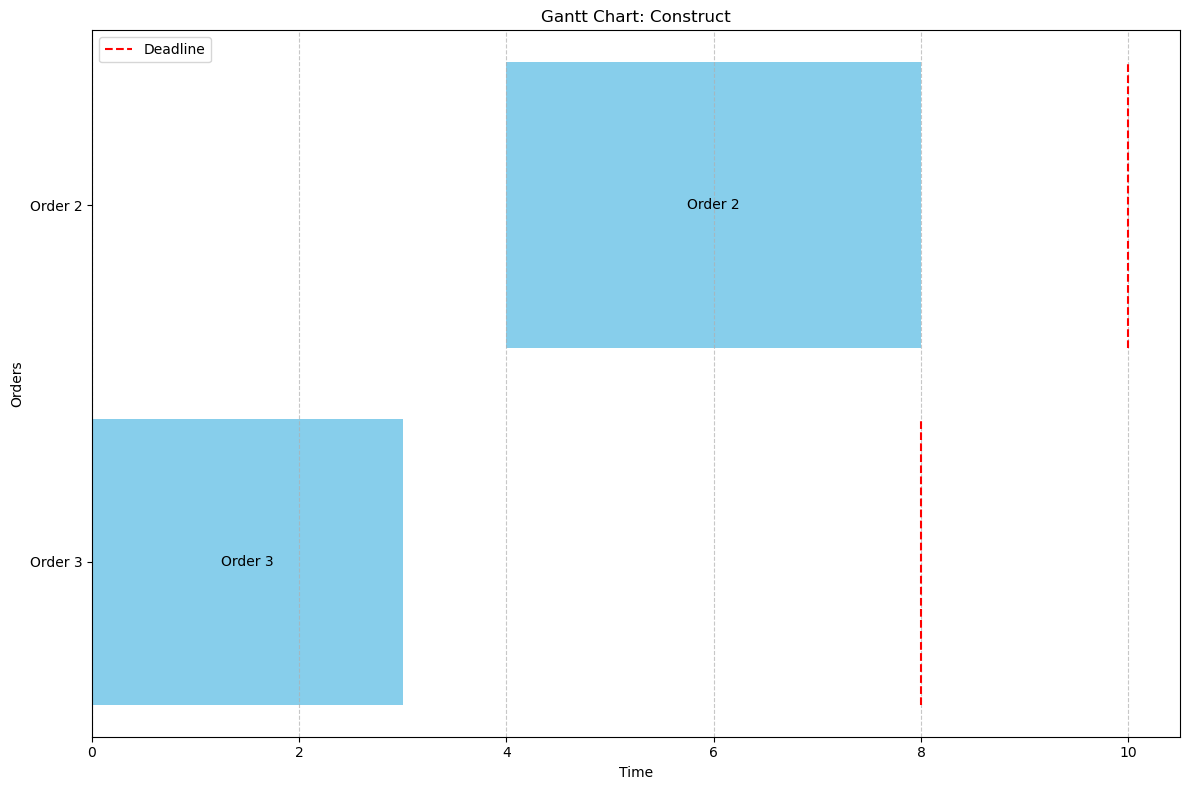

Results for OAS0.txt using Construct:
Scheduled Orders: [3, 2]
Total Profit: 13.0
Run Time: 0.0010 seconds
--------------------------------------------------


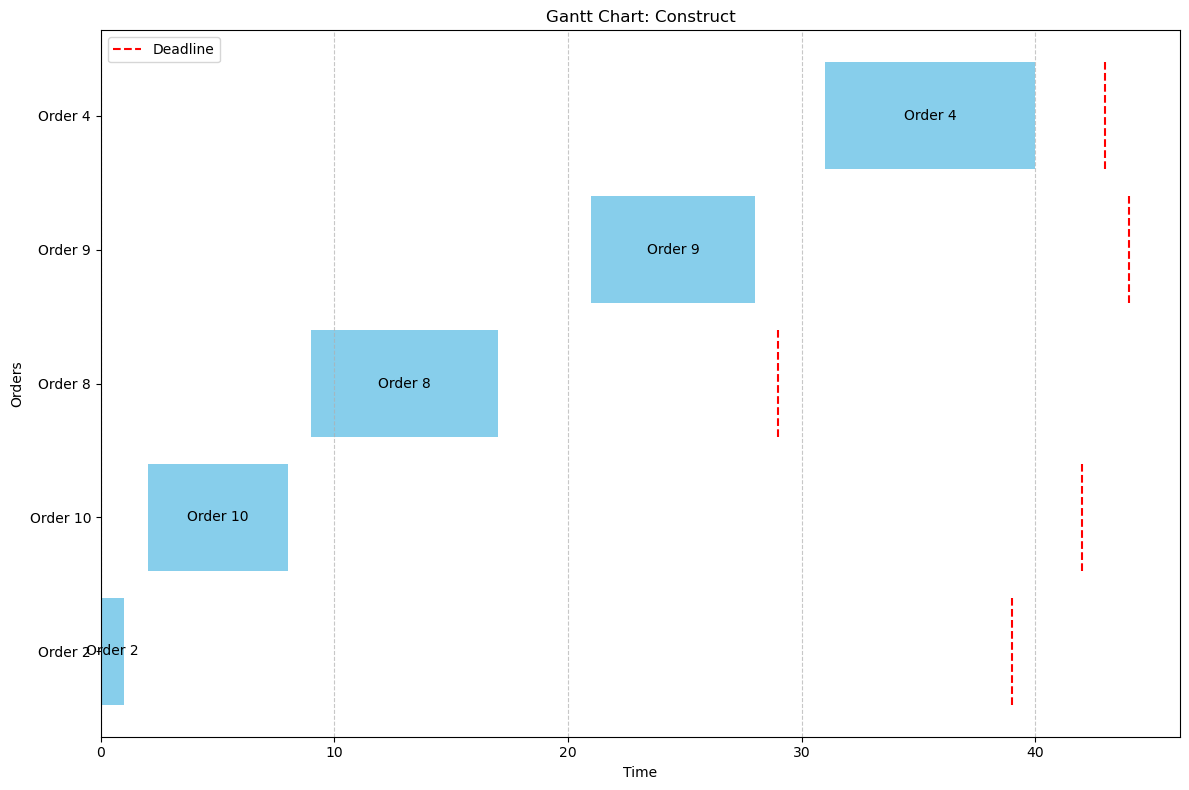

Results for OAS1.txt using Construct:
Scheduled Orders: [2, 10, 8, 9, 4]
Total Profit: 380.0
Run Time: 0.0010 seconds
--------------------------------------------------


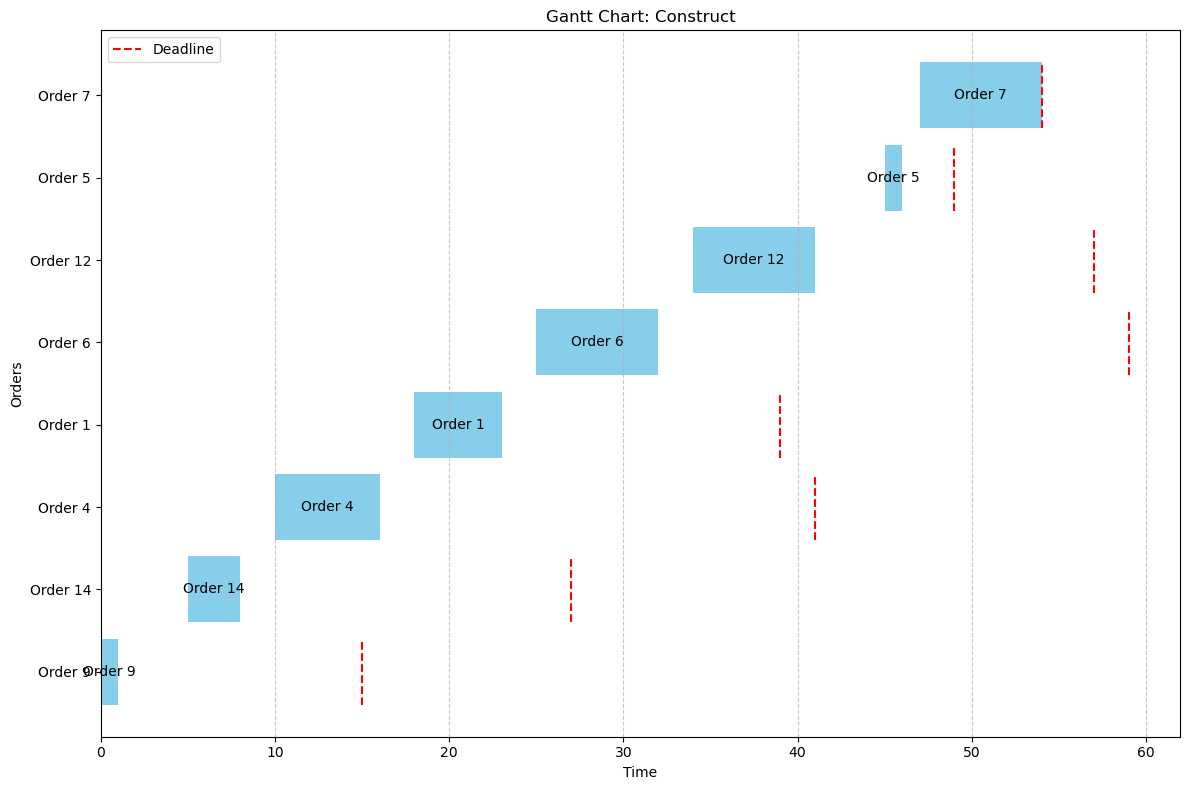

Results for OAS2.txt using Construct:
Scheduled Orders: [9, 14, 4, 1, 6, 12, 5, 7]
Total Profit: 426.703297
Run Time: 0.0020 seconds
--------------------------------------------------


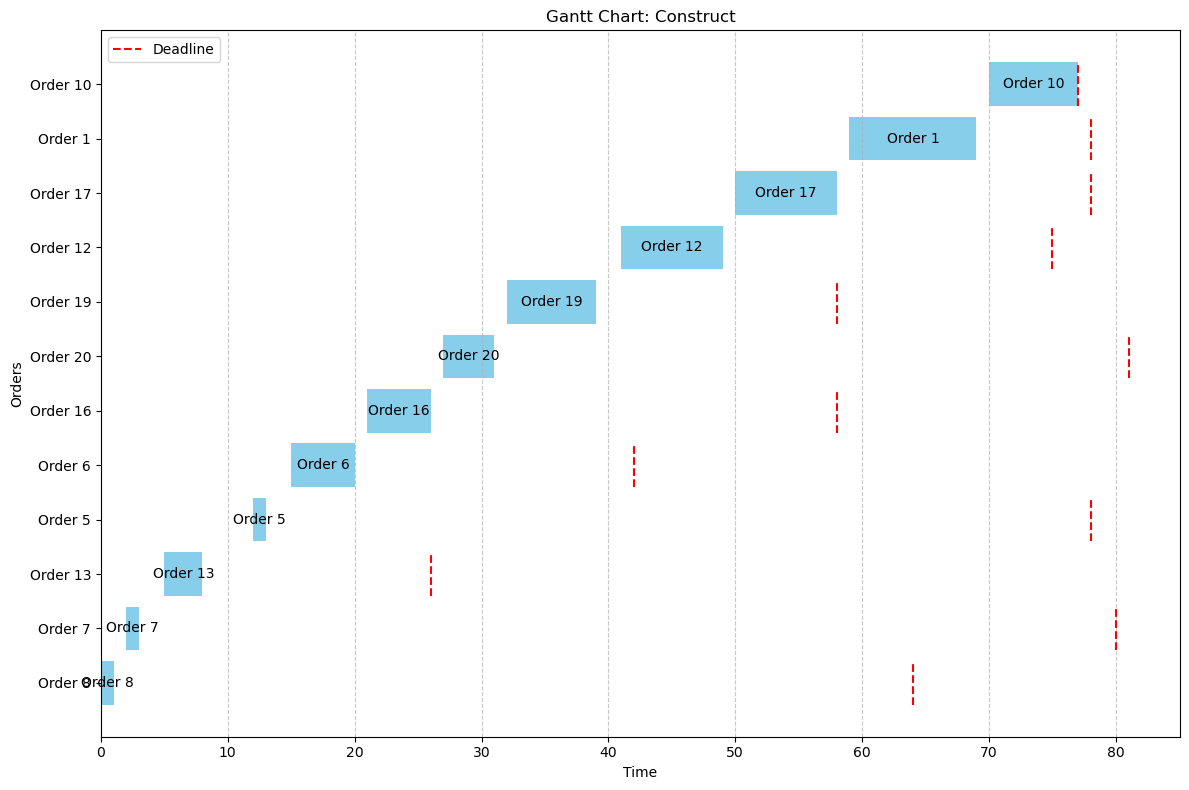

Results for OAS3.txt using Construct:
Scheduled Orders: [8, 7, 13, 5, 6, 16, 20, 19, 12, 17, 1, 10]
Total Profit: 787.466679
Run Time: 0.0020 seconds
--------------------------------------------------


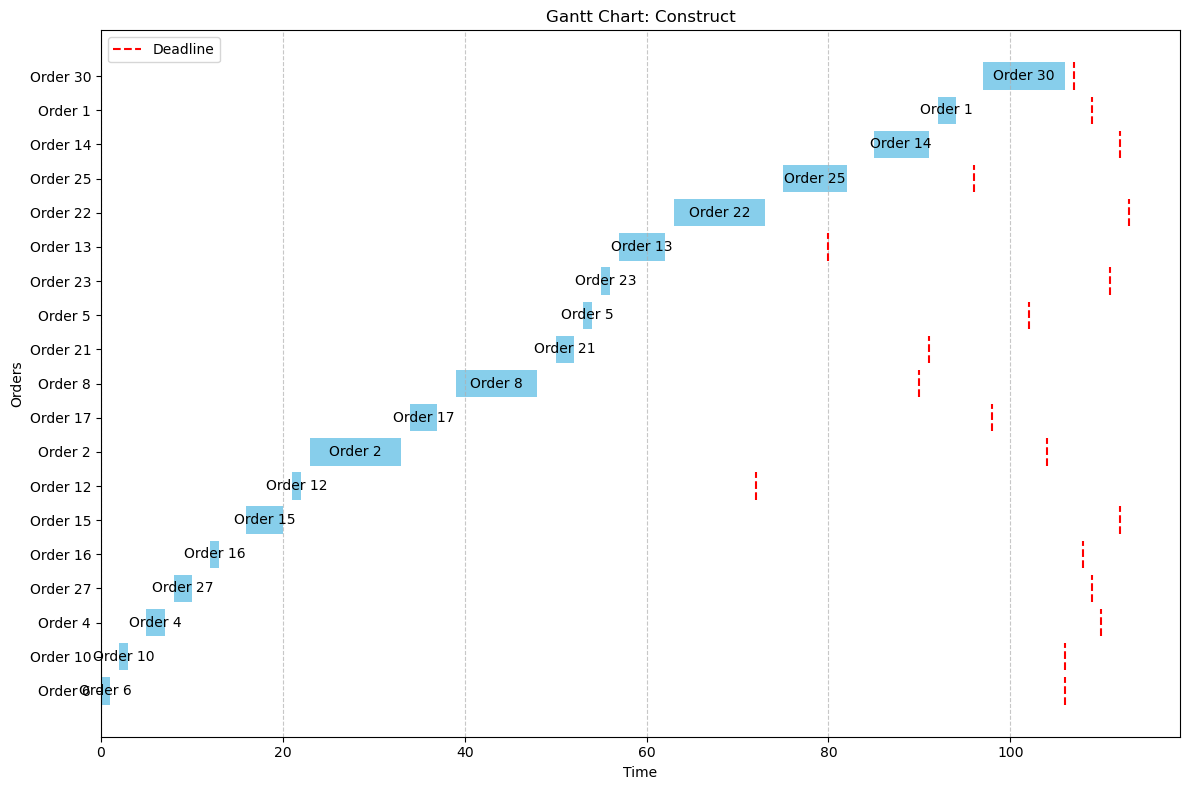

Results for OAS4.txt using Construct:
Scheduled Orders: [6, 10, 4, 27, 16, 15, 12, 2, 17, 8, 21, 5, 23, 13, 22, 25, 14, 1, 30]
Total Profit: 859.055555
Run Time: 0.0050 seconds
--------------------------------------------------


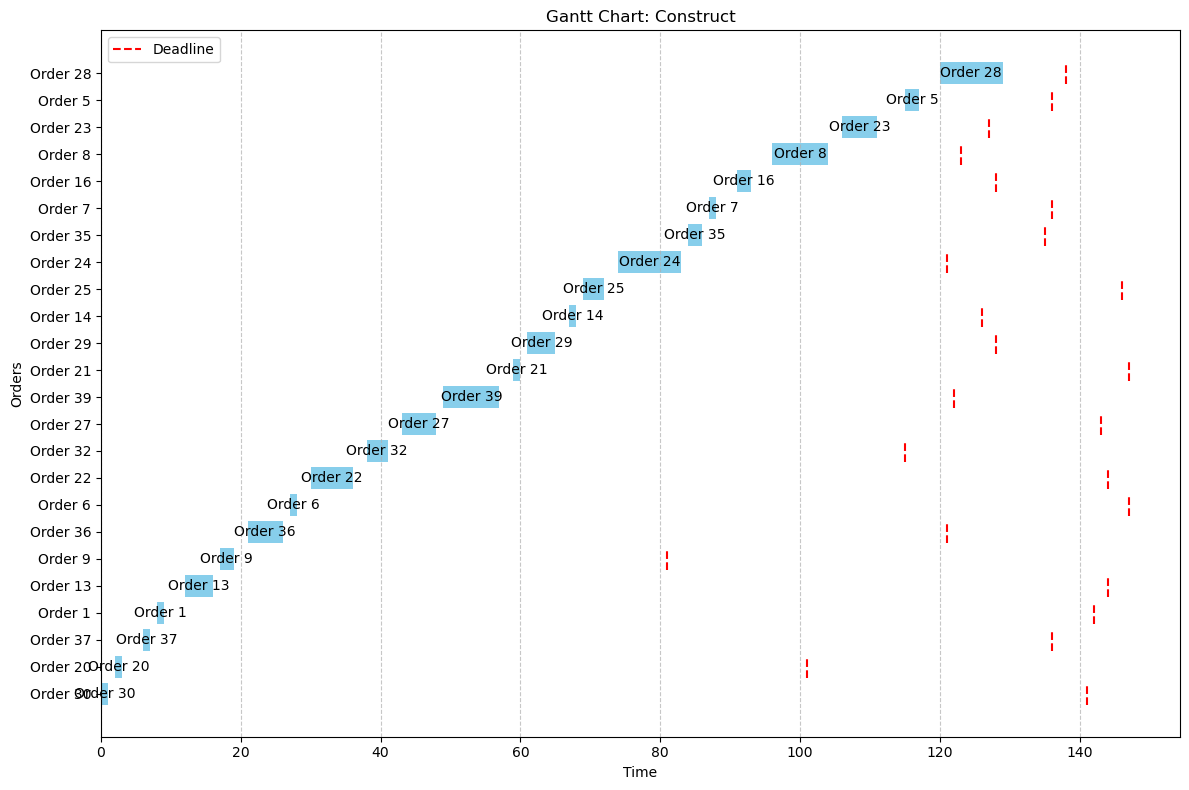

Results for OAS5.txt using Construct:
Scheduled Orders: [30, 20, 37, 1, 13, 9, 36, 6, 22, 32, 27, 39, 21, 29, 14, 25, 24, 35, 7, 16, 8, 23, 5, 28]
Total Profit: 1160.074094
Run Time: 0.0050 seconds
--------------------------------------------------


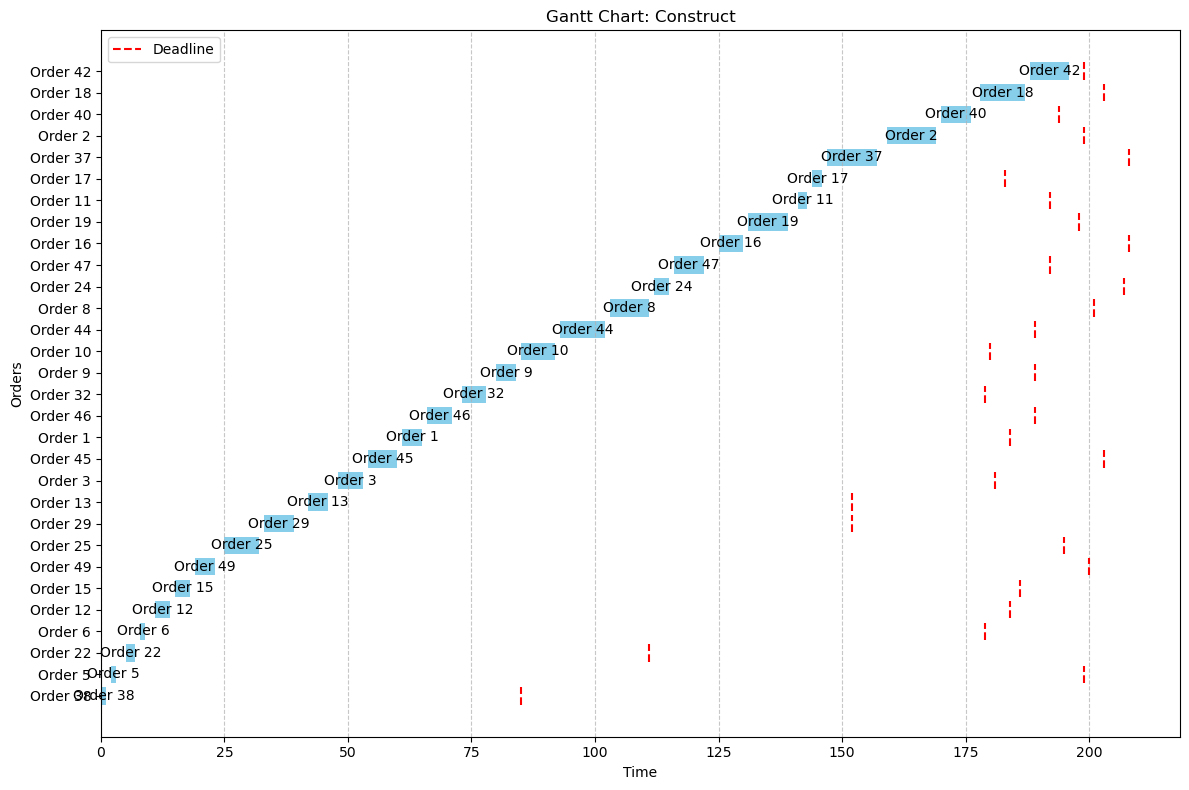

Results for OAS6.txt using Construct:
Scheduled Orders: [38, 5, 22, 6, 12, 15, 49, 25, 29, 13, 3, 45, 1, 46, 32, 9, 10, 44, 8, 24, 47, 16, 19, 11, 17, 37, 2, 40, 18, 42]
Total Profit: 1623.649228
Run Time: 0.0075 seconds
--------------------------------------------------


In [12]:
for file_name in file_names:
    Run_and_visualize(file_name, construct, "Construct")

### 5. Local Search Improvement Heuristics

#### **Functions**

In [13]:
def Run_and_visualize_improved(file_name, heuristic_function, heuristic_name):
    start_time = time.time()

    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)
    
    initial_solution, _ = construct(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)

    scheduled_orders, total_profit = heuristic_function(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)

    end_time = time.time()

    elapsed_time = end_time - start_time

    visualize(duration, setup, deadline, scheduled_orders, heuristic_name)

    print_results(file_name, scheduled_orders, total_profit, elapsed_time, heuristic_name)


#### **5.1 Move()**

- ***Code : First Accept***

In [34]:
def move(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders):
    """
    Local search using First_Accept.
    Tries to improve the solution by moving an order to a different position or
    adding an order to the schedule.
    """
    def calculate_profit(sequence):
        """
        Evaluates the feasibility and profit of a sequence.
        Returns None if the sequence is infeasible, or the total profit otherwise.
        """
        try:
            start_times, _ = cal(duration, setup, sequence)
            return eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence)
        except Exception:
            return None

    # Track the best solution and its profit
    best_solution = initial_solution.copy()
    best_profit = calculate_profit(best_solution)

    improved = True
    while improved:
        improved = False

        # Try removing each order in the current solution and reinserting it
        for i in range(len(best_solution)):
            # Work on a copy of the current solution
            current_solution = best_solution.copy()
            order_to_move = current_solution.pop(i)  # Remove the order

            for j in range(len(current_solution) + 1):
                tentative_solution = current_solution[:j] + [order_to_move] + current_solution[j:]
                tentative_profit = calculate_profit(tentative_solution)

                if tentative_profit is not None and tentative_profit > best_profit:
                    best_solution = tentative_solution
                    best_profit = tentative_profit
                    improved = True
                    break 

        # Try adding orders not in the current solution
        for order in range(numberOrders):
            if order not in best_solution:
                for j in range(len(best_solution) + 1):
                    tentative_solution = best_solution[:j] + [order] + best_solution[j:]
                    tentative_profit = calculate_profit(tentative_solution)

                    if tentative_profit is not None and tentative_profit > best_profit:
                        best_solution = tentative_solution
                        best_profit = tentative_profit
                        improved = True
                        break 

    return best_solution, best_profit


- ***Visualize :***

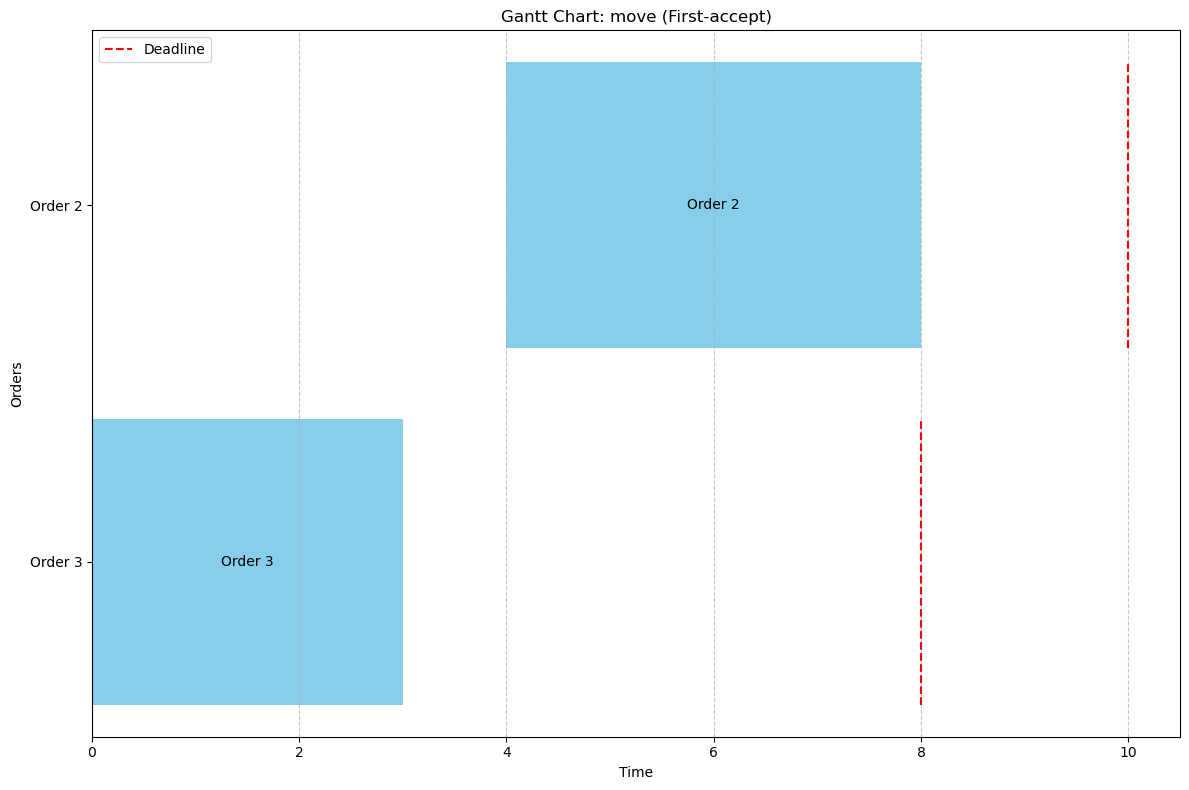

Results for OAS0.txt using move (First-accept):
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0339 seconds
--------------------------------------------------


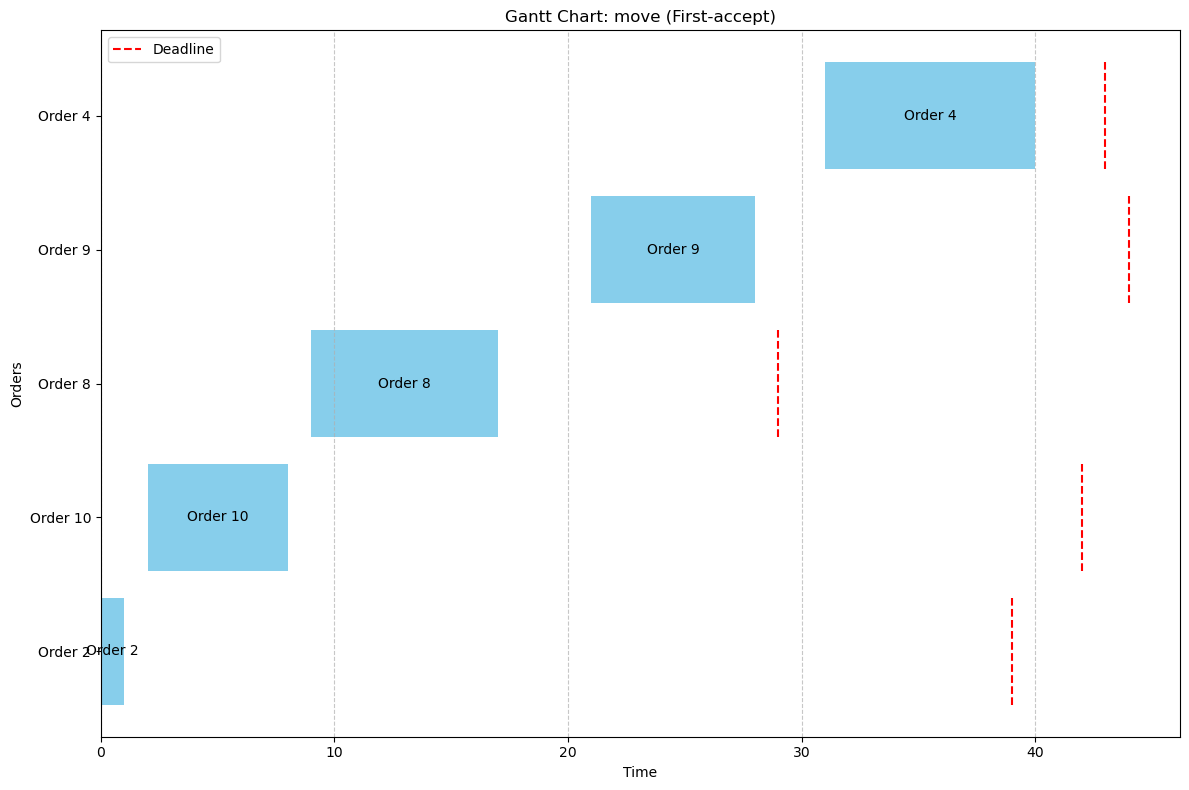

Results for OAS1.txt using move (First-accept):
Scheduled Orders: [2, 10, 8, 9, 4]
Total Profit: 380
Run Time: 0.0050 seconds
--------------------------------------------------


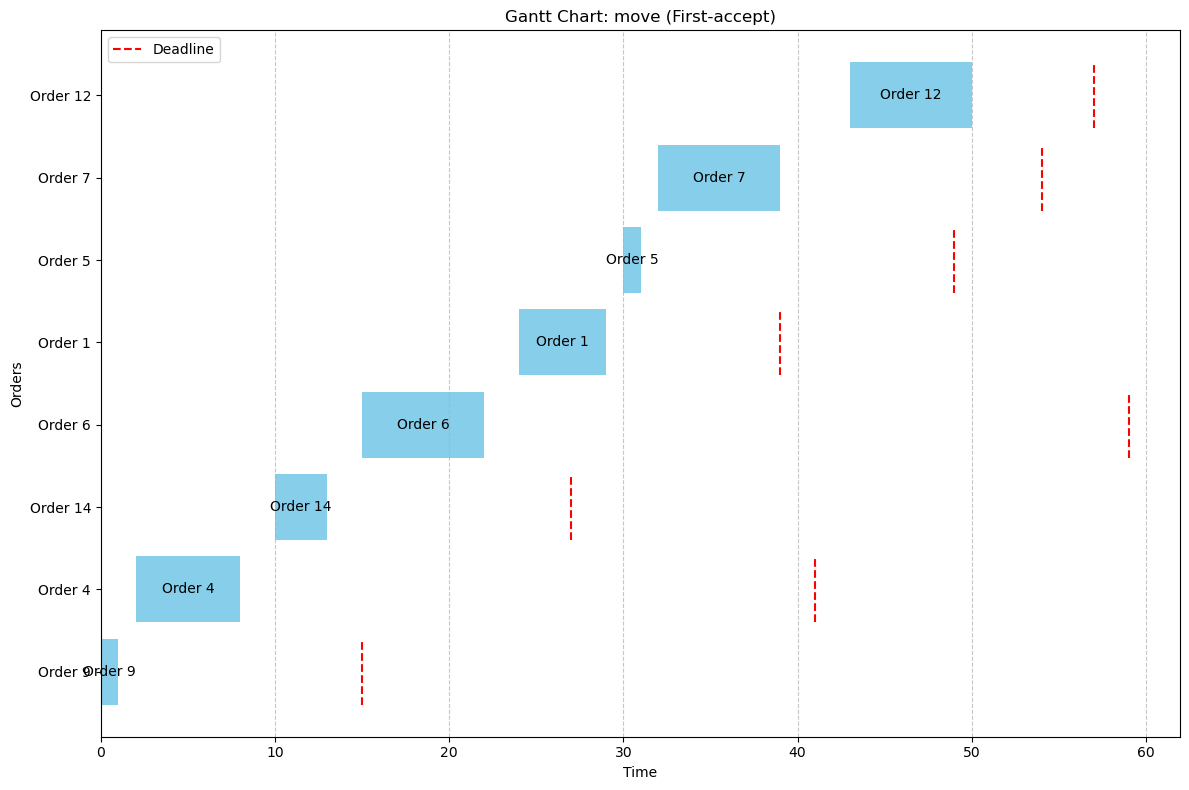

Results for OAS2.txt using move (First-accept):
Scheduled Orders: [9, 4, 14, 6, 1, 5, 7, 12]
Total Profit: 391.500002
Run Time: 0.0129 seconds
--------------------------------------------------


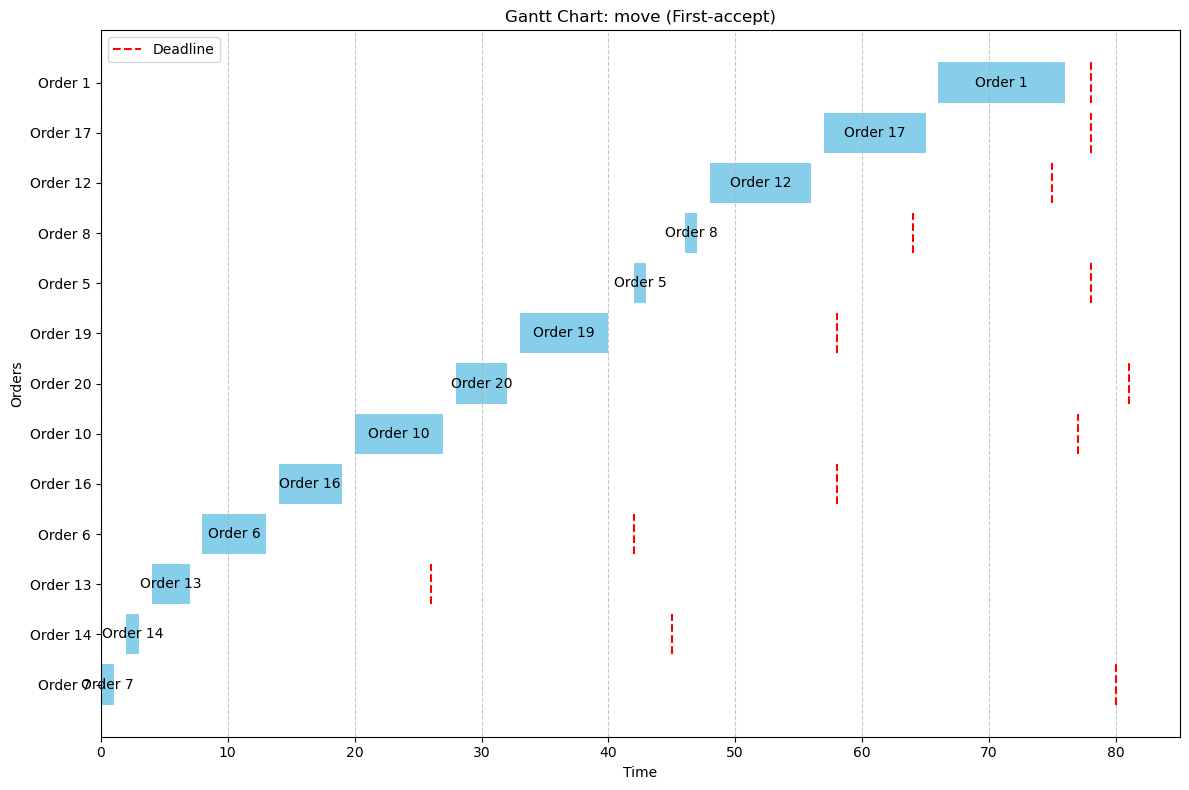

Results for OAS3.txt using move (First-accept):
Scheduled Orders: [7, 14, 13, 6, 16, 10, 20, 19, 5, 8, 12, 17, 1]
Total Profit: 872
Run Time: 0.0459 seconds
--------------------------------------------------


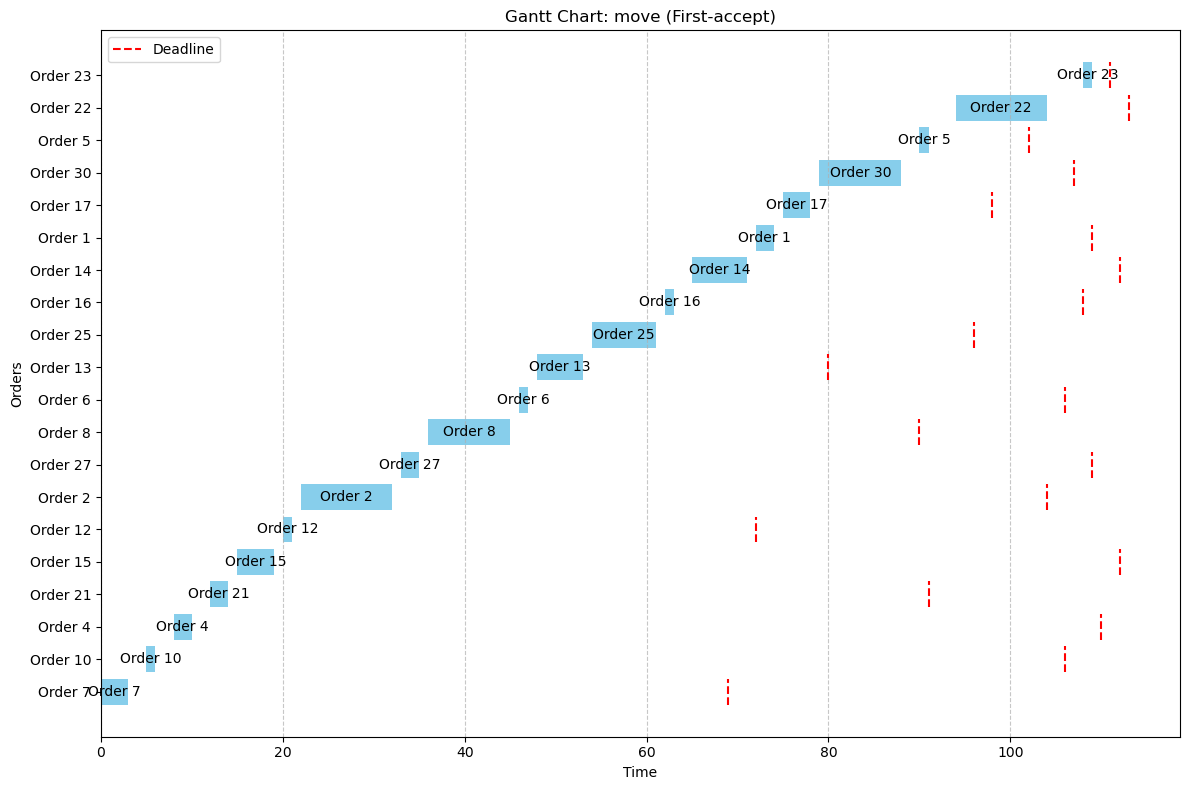

Results for OAS4.txt using move (First-accept):
Scheduled Orders: [7, 10, 4, 21, 15, 12, 2, 27, 8, 6, 13, 25, 16, 14, 1, 17, 30, 5, 22, 23]
Total Profit: 875
Run Time: 0.1516 seconds
--------------------------------------------------


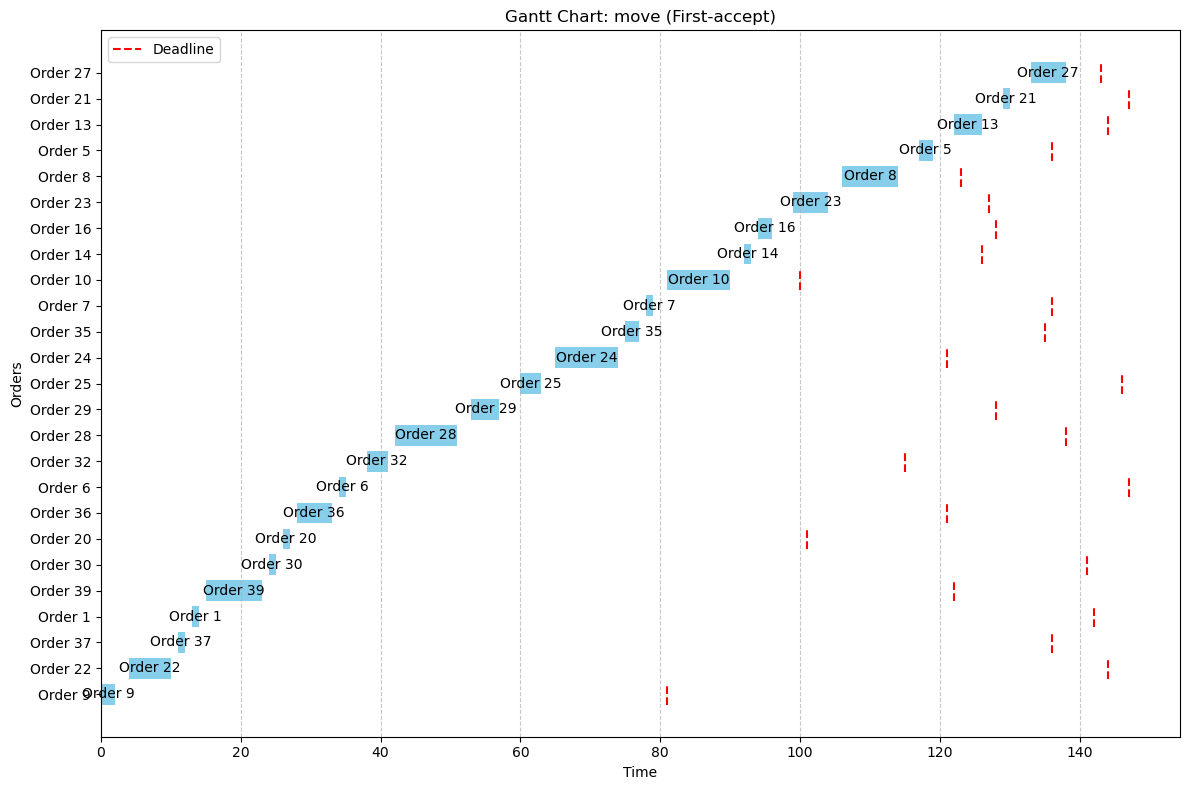

Results for OAS5.txt using move (First-accept):
Scheduled Orders: [9, 22, 37, 1, 39, 30, 20, 36, 6, 32, 28, 29, 25, 24, 35, 7, 10, 14, 16, 23, 8, 5, 13, 21, 27]
Total Profit: 1202
Run Time: 0.3949 seconds
--------------------------------------------------


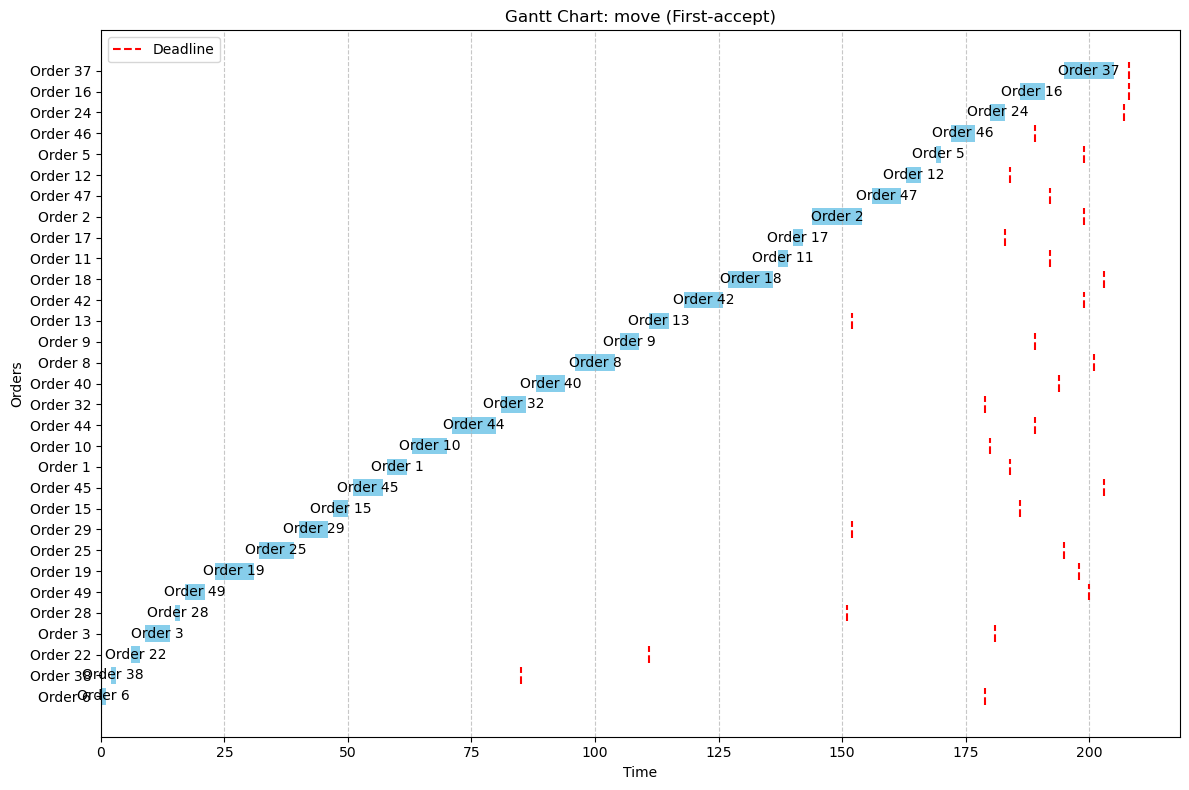

Results for OAS6.txt using move (First-accept):
Scheduled Orders: [6, 38, 22, 3, 28, 49, 19, 25, 29, 15, 45, 1, 10, 44, 32, 40, 8, 9, 13, 42, 18, 11, 17, 2, 47, 12, 5, 46, 24, 16, 37]
Total Profit: 1660
Run Time: 1.0423 seconds
--------------------------------------------------


In [35]:
for file_name in file_names:
    Run_and_visualize_improved(file_name, move, "move (First-accept)")

- ***Code : Best-accept***

In [36]:
def move_best_accept(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders):
    """
    Local search using Best-accept.
    Tries to improve the solution by evaluating all neighbors and selecting the best one.
    """
    def calculate_profit(sequence):
        """
        Evaluates the feasibility and profit of a sequence.
        Returns None if the sequence is infeasible, or the total profit otherwise.
        """
        try:
            start_times, _ = cal(duration, setup, sequence)
            return eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence)
        except Exception:
            return None

    # Track the best solution and its profit
    best_solution = initial_solution.copy()
    best_profit = calculate_profit(best_solution)

    improved = True
    while improved:
        improved = False

        # Try removing each order in the current solution and reinserting it
        for i in range(len(best_solution)):
            current_solution = best_solution.copy()
            order_to_move = current_solution.pop(i) 

            for j in range(len(current_solution) + 1):
                tentative_solution = current_solution[:j] + [order_to_move] + current_solution[j:]
                tentative_profit = calculate_profit(tentative_solution)

                if tentative_profit is not None and tentative_profit > best_profit:
                    best_solution = tentative_solution
                    best_profit = tentative_profit
                    improved = True

        # Try adding orders not in the current solution
        for order in range(numberOrders):
            if order not in best_solution:
                for j in range(len(best_solution) + 1):
                    tentative_solution = best_solution[:j] + [order] + best_solution[j:]
                    tentative_profit = calculate_profit(tentative_solution)

                    if tentative_profit is not None and tentative_profit > best_profit:
                        best_solution = tentative_solution
                        best_profit = tentative_profit
                        improved = True

    return best_solution, best_profit


- ***Run best_accept Move :***

In [38]:
for file_name in file_names:
    def Run_and_visualize_best_accept(file_name, heuristic_function, heuristic_name):
        start_time = time.time()

        duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)
    
        initial_solution, _ = construct(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)

        scheduled_orders, total_profit = heuristic_function(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)

        end_time = time.time()

        elapsed_time = end_time - start_time

        print_results(file_name, scheduled_orders, total_profit, elapsed_time, heuristic_name)

    Run_and_visualize_best_accept(file_name, move_best_accept, "move (Best accept)")

Results for OAS0.txt using move (Best accept):
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0607 seconds
--------------------------------------------------
Results for OAS1.txt using move (Best accept):
Scheduled Orders: [2, 10, 8, 9, 4]
Total Profit: 380
Run Time: 0.0086 seconds
--------------------------------------------------
Results for OAS2.txt using move (Best accept):
Scheduled Orders: [9, 4, 14, 6, 1, 5, 7, 12]
Total Profit: 391.500002
Run Time: 0.0124 seconds
--------------------------------------------------
Results for OAS3.txt using move (Best accept):
Scheduled Orders: [7, 14, 13, 6, 16, 10, 20, 19, 5, 8, 12, 17, 1]
Total Profit: 872
Run Time: 0.0318 seconds
--------------------------------------------------
Results for OAS4.txt using move (Best accept):
Scheduled Orders: [7, 10, 4, 21, 15, 12, 2, 27, 8, 6, 13, 25, 16, 14, 1, 17, 30, 5, 22, 23]
Total Profit: 875
Run Time: 0.1150 seconds
--------------------------------------------------
Results for OAS5.txt using

#### **5.2 Swap()**

- ***Code :***

In [16]:
def swap(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders):
    """
    Local search using Swap.
    Tries to improve the solution by swapping the positions of two orders in the schedule.
    """
    def calculate_profit(sequence):
        """
        Evaluates the feasibility and profit of a sequence.
        Returns None if the sequence is infeasible, or the total profit otherwise.
        """
        try:
            start_times, _ = cal(duration, setup, sequence)
            return eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence)
        except Exception:
            return None

    # Track the best solution and its profit
    best_solution = initial_solution.copy()
    best_profit = calculate_profit(best_solution)

    improved = True
    while improved:
        improved = False

        # Try swapping each pair of orders
        for i in range(len(best_solution)):
            for j in range(i + 1, len(best_solution)):
                # Swap orders i and j
                current_solution = best_solution.copy()
                current_solution[i], current_solution[j] = current_solution[j], current_solution[i]

                tentative_profit = calculate_profit(current_solution)

                # Update the best solution if the swap improves profit
                if tentative_profit is not None and tentative_profit > best_profit:
                    best_solution = current_solution
                    best_profit = tentative_profit
                    improved = True
                    break
            if improved:  # If improvement was found, restart the search
                break

    return best_solution, best_profit

- ***Visualize :***

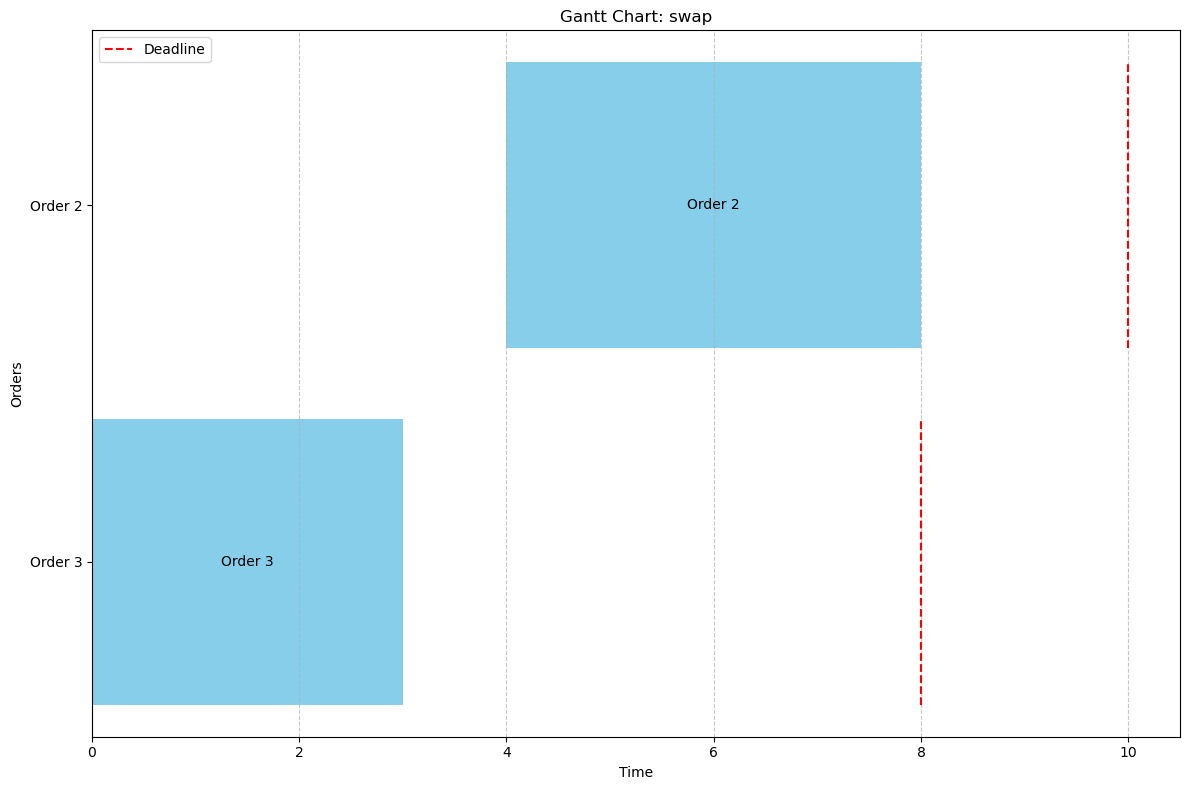

Results for OAS0.txt using swap:
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0010 seconds
--------------------------------------------------


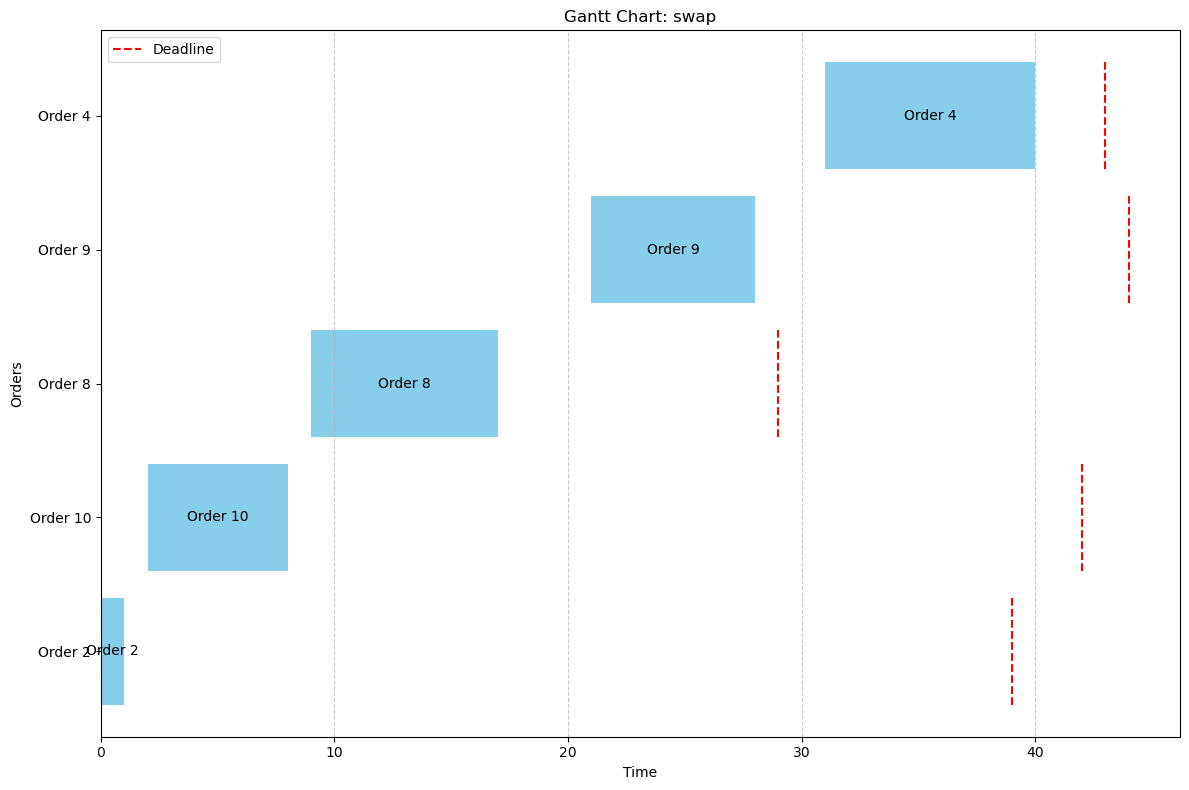

Results for OAS1.txt using swap:
Scheduled Orders: [2, 10, 8, 9, 4]
Total Profit: 380
Run Time: 0.0020 seconds
--------------------------------------------------


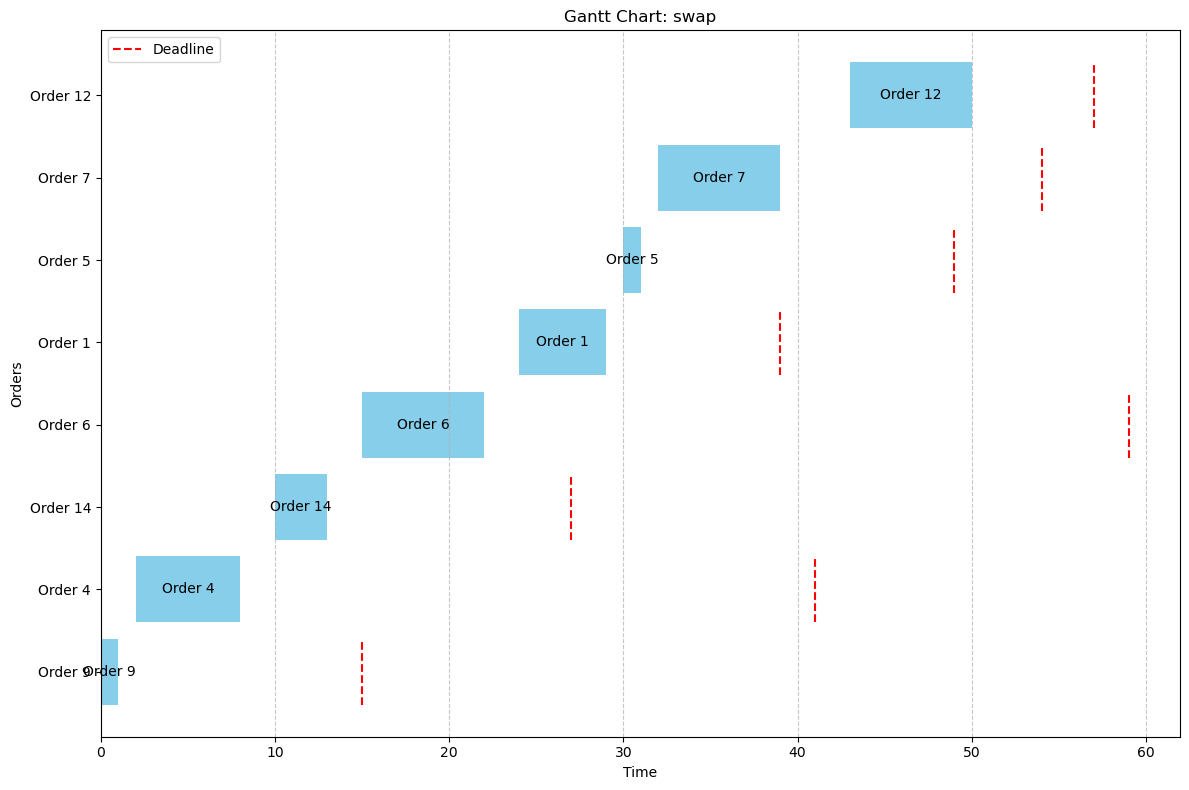

Results for OAS2.txt using swap:
Scheduled Orders: [9, 4, 14, 6, 1, 5, 7, 12]
Total Profit: 391.500002
Run Time: 0.0050 seconds
--------------------------------------------------


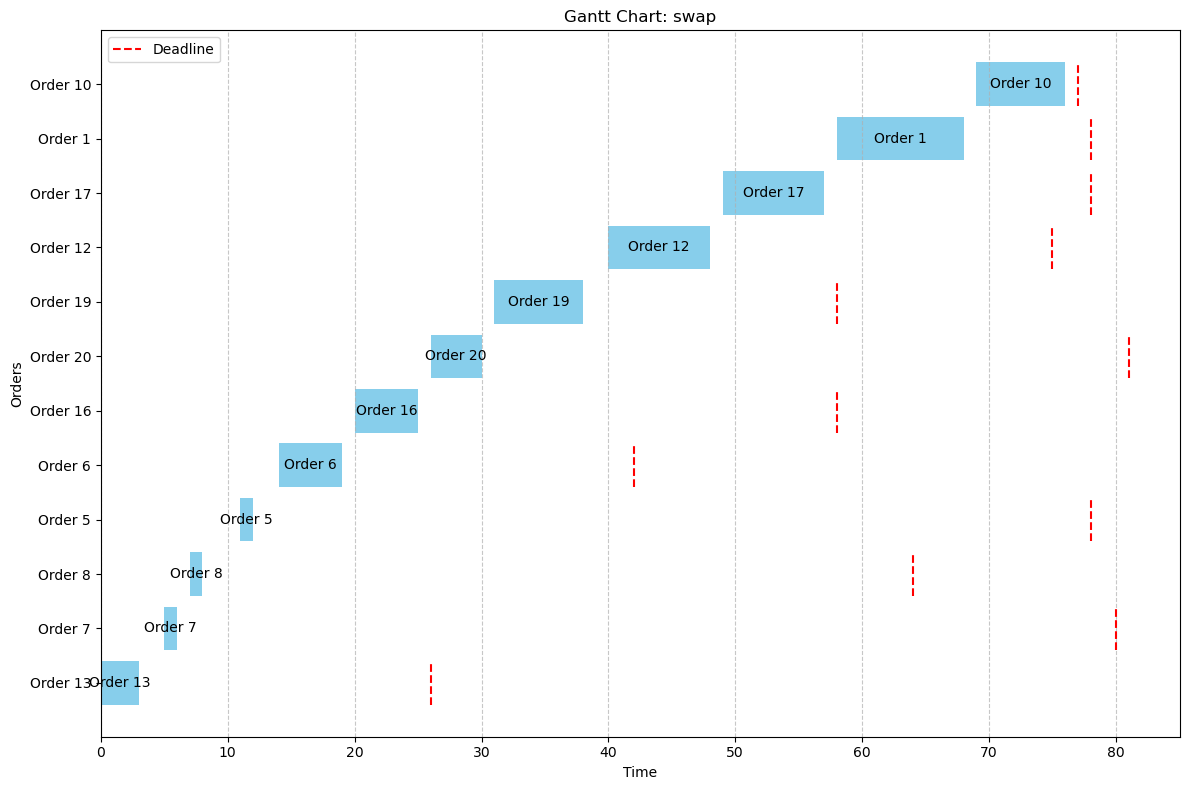

Results for OAS3.txt using swap:
Scheduled Orders: [13, 7, 8, 5, 6, 16, 20, 19, 12, 17, 1, 10]
Total Profit: 686.933348
Run Time: 0.0060 seconds
--------------------------------------------------


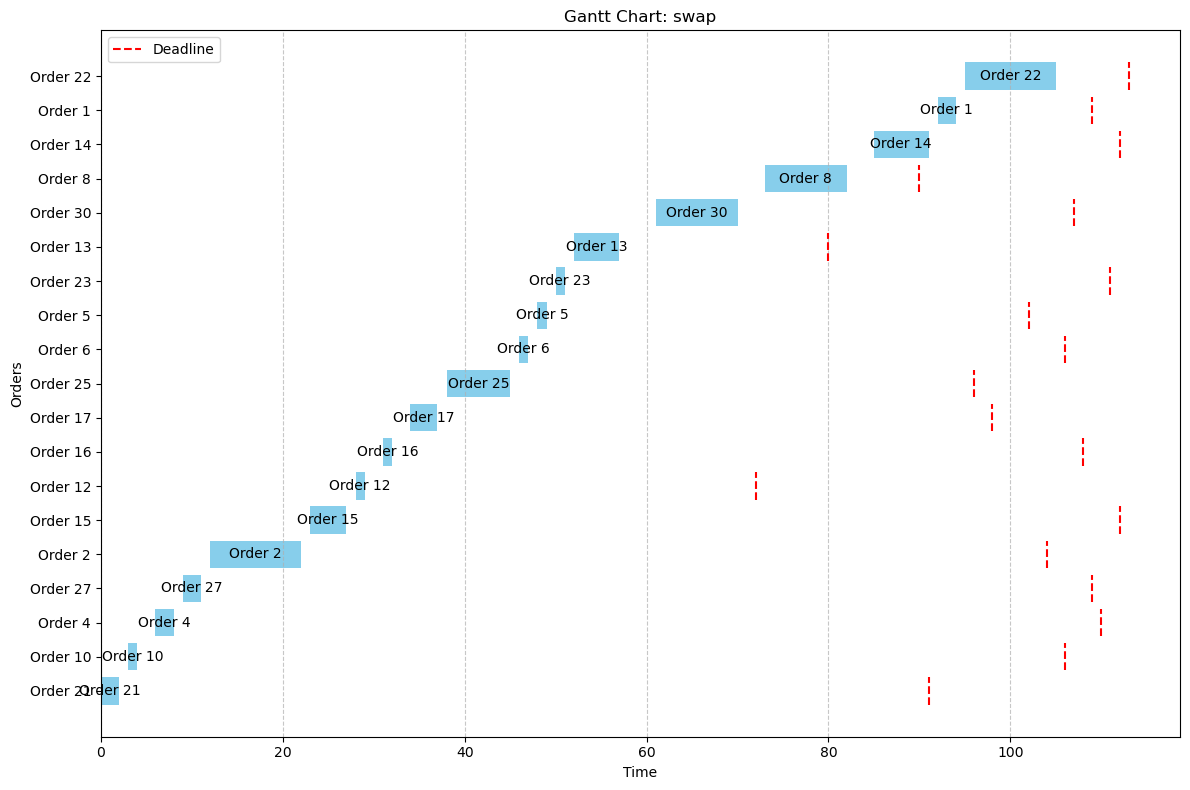

Results for OAS4.txt using swap:
Scheduled Orders: [21, 10, 4, 27, 2, 15, 12, 16, 17, 25, 6, 5, 23, 13, 30, 8, 14, 1, 22]
Total Profit: 861
Run Time: 0.0389 seconds
--------------------------------------------------


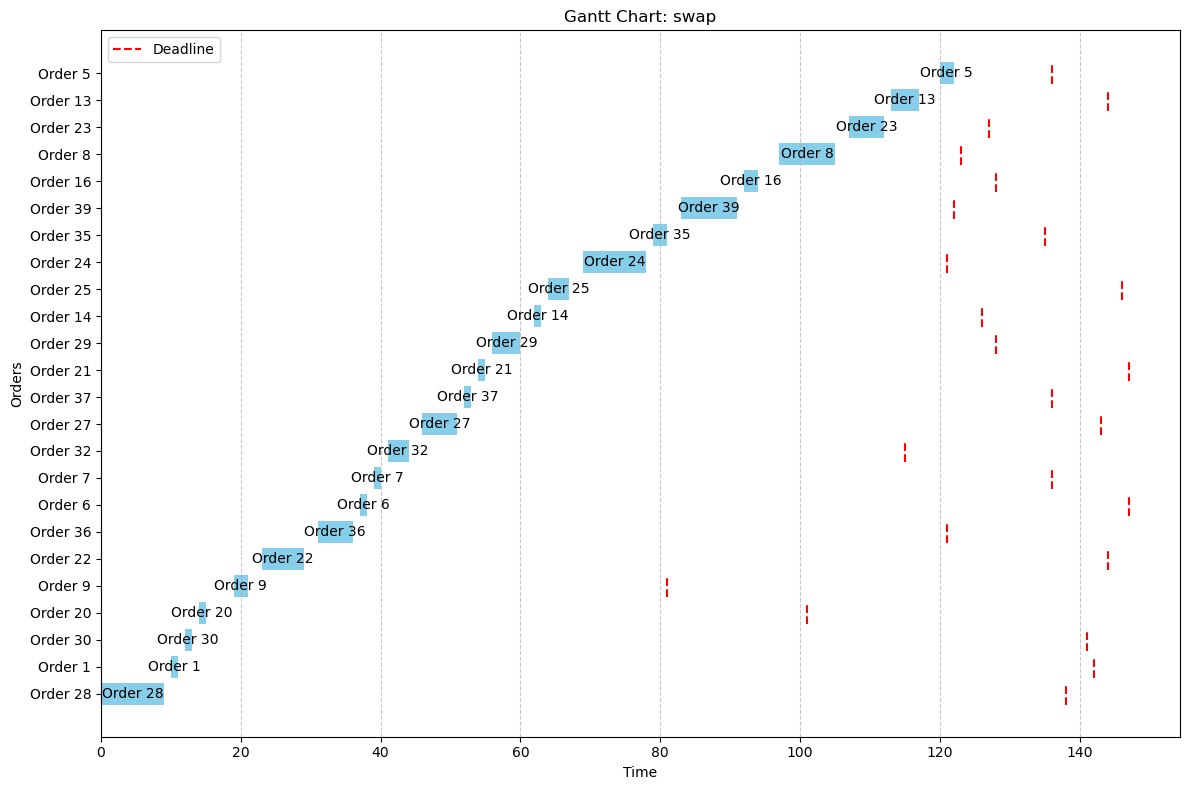

Results for OAS5.txt using swap:
Scheduled Orders: [28, 1, 30, 20, 9, 22, 36, 6, 7, 32, 27, 37, 21, 29, 14, 25, 24, 35, 39, 16, 8, 23, 13, 5]
Total Profit: 1180
Run Time: 0.0439 seconds
--------------------------------------------------


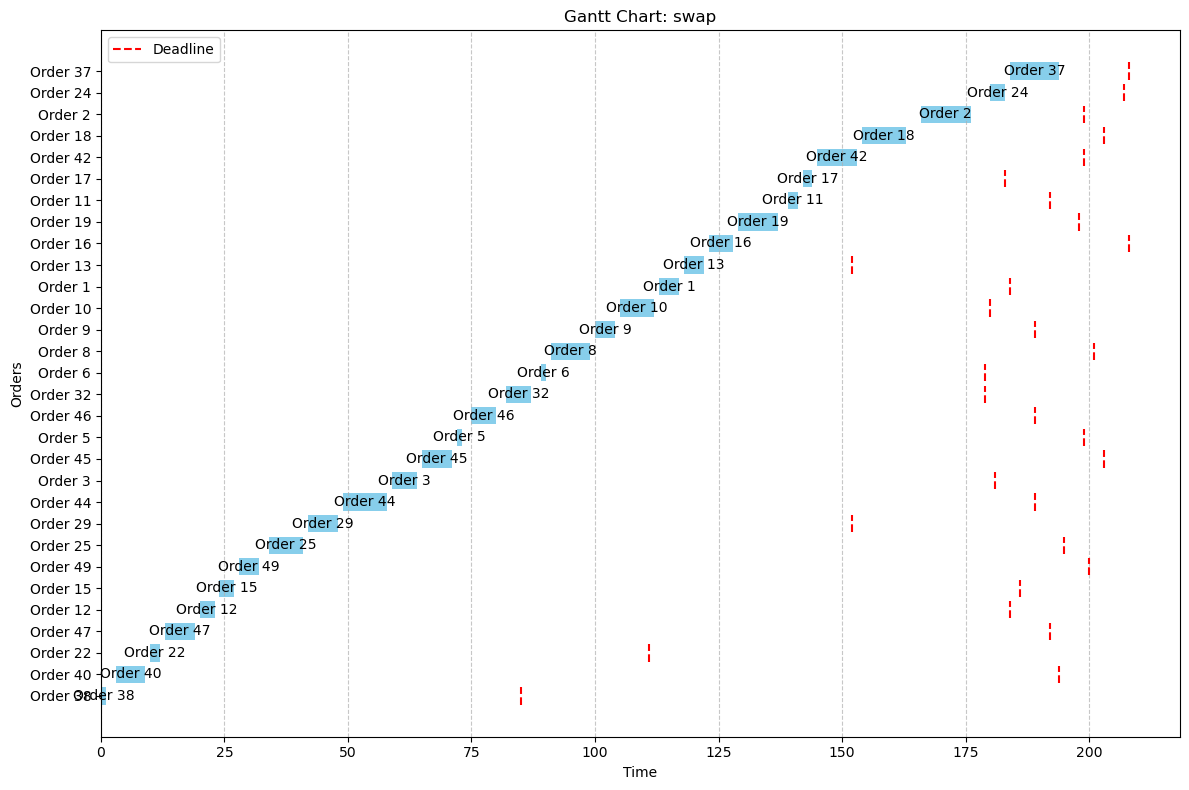

Results for OAS6.txt using swap:
Scheduled Orders: [38, 40, 22, 47, 12, 15, 49, 25, 29, 44, 3, 45, 5, 46, 32, 6, 8, 9, 10, 1, 13, 16, 19, 11, 17, 42, 18, 2, 24, 37]
Total Profit: 1650
Run Time: 0.4283 seconds
--------------------------------------------------


In [17]:
for file_name in file_names:
    Run_and_visualize_improved(file_name, swap, "swap")

#### **5.3 Improve()**

- ***Code :***

In [18]:
def improve(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders, max_iterations= 100):
    """
    Local search improvement heuristic using Reverse and Swap heuristics.
    Iteratively applies these operators to improve the solution until no further improvement is found.
    """
    def calculate_profit(sequence):
        """
        Evaluates the feasibility and profit of a sequence.
        Returns None if the sequence is infeasible, or the total profit otherwise.
        """
        try:
            start_times, _ = cal(duration, setup, sequence)
            return eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence)
        except Exception:
            return None

    # Initialize with the initial solution
    current_solution = initial_solution[:]
    best_solution = current_solution
    best_profit = calculate_profit(current_solution)

    iteration = 0
    while iteration < max_iterations:
        iteration += 1
        improved = False
       
        '''Apply Reverse heuristic'''
        for i in range(len(current_solution) - 1):
            for j in range(i + 1, len(current_solution)):
                # Reverse the order of orders between i and j
                new_solution = current_solution[:i] + current_solution[i:j + 1][::-1] + current_solution[j + 1:]
                new_profit = calculate_profit(new_solution)
                if new_profit is not None and new_profit > best_profit:
                    best_solution = new_solution
                    best_profit = new_profit
                    improved = True

        # Apply Move heuristic
        moved_solution, moved_profit = move(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
        if moved_profit > best_profit:
            best_solution = moved_solution
            best_profit = moved_profit
            improved = True

        # If no improvement is found, terminate
        if not improved:
            break

        # Update the current solution for the next iteration
        current_solution = best_solution

    return best_solution, best_profit

- ***Visualize :***

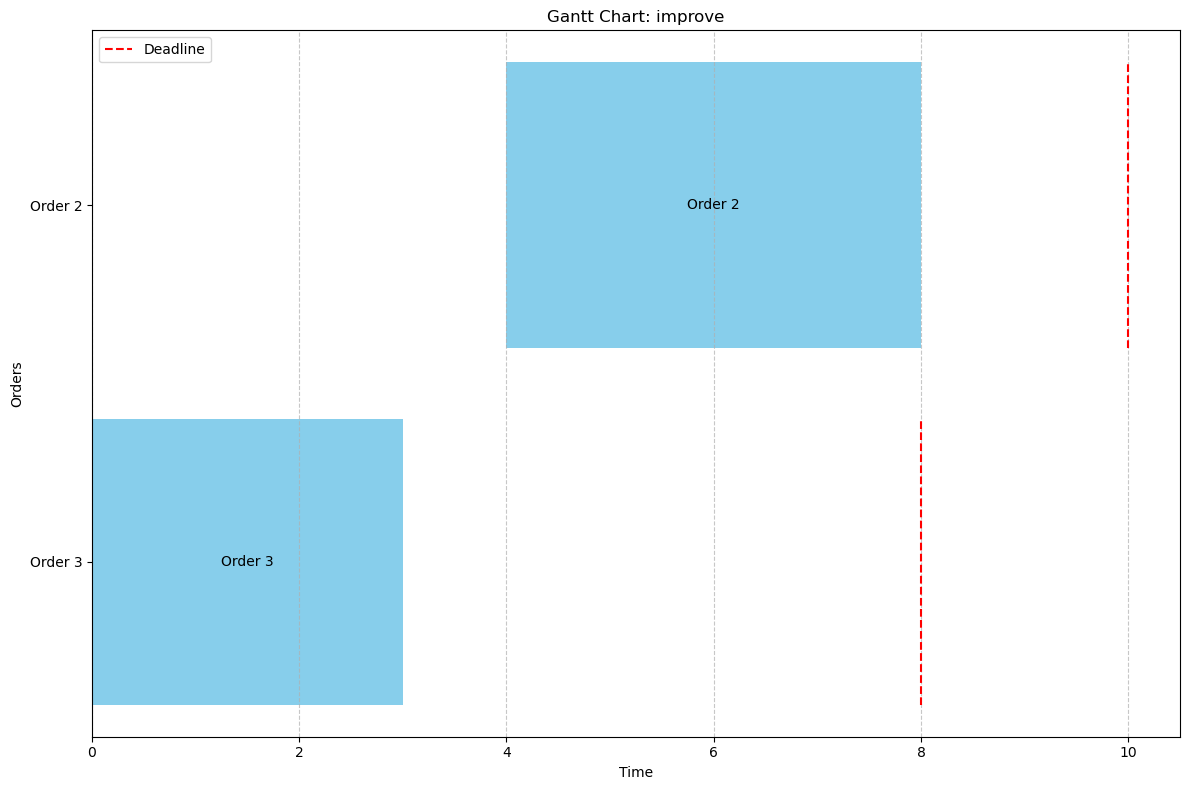

Results for OAS0.txt using improve:
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0010 seconds
--------------------------------------------------


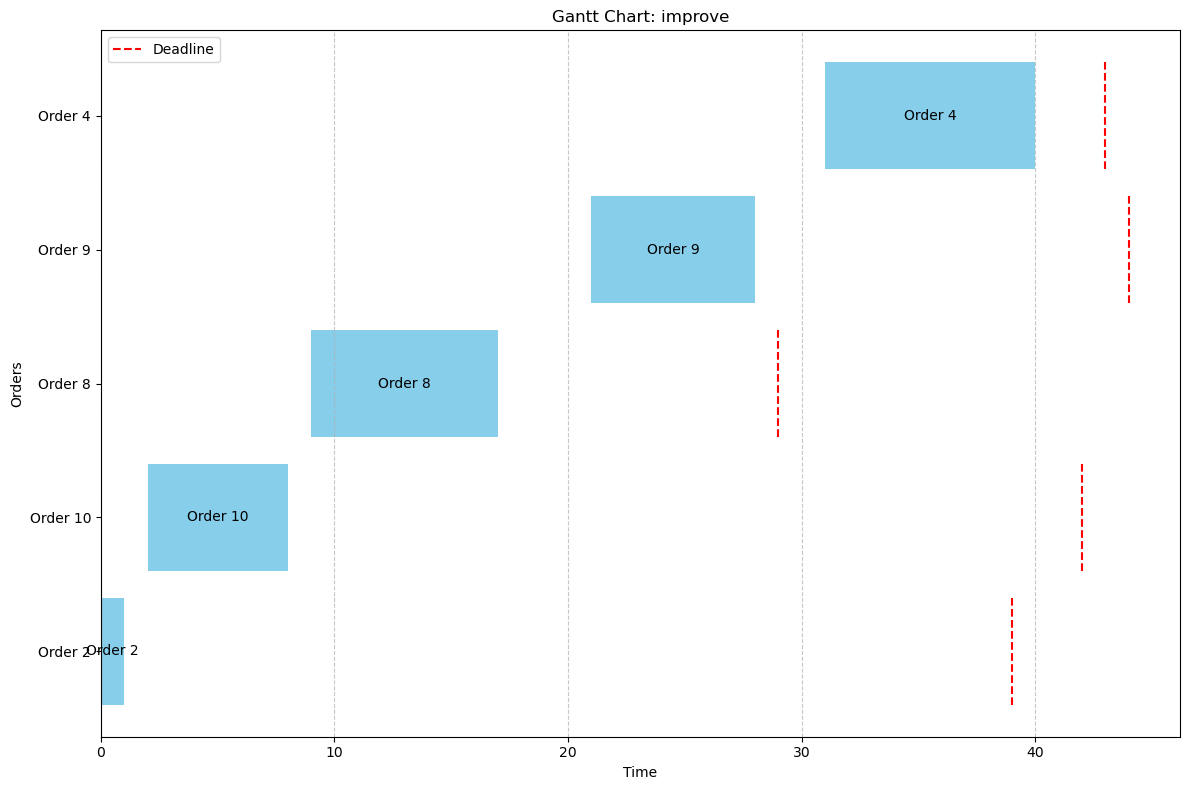

Results for OAS1.txt using improve:
Scheduled Orders: [2, 10, 8, 9, 4]
Total Profit: 380
Run Time: 0.0070 seconds
--------------------------------------------------


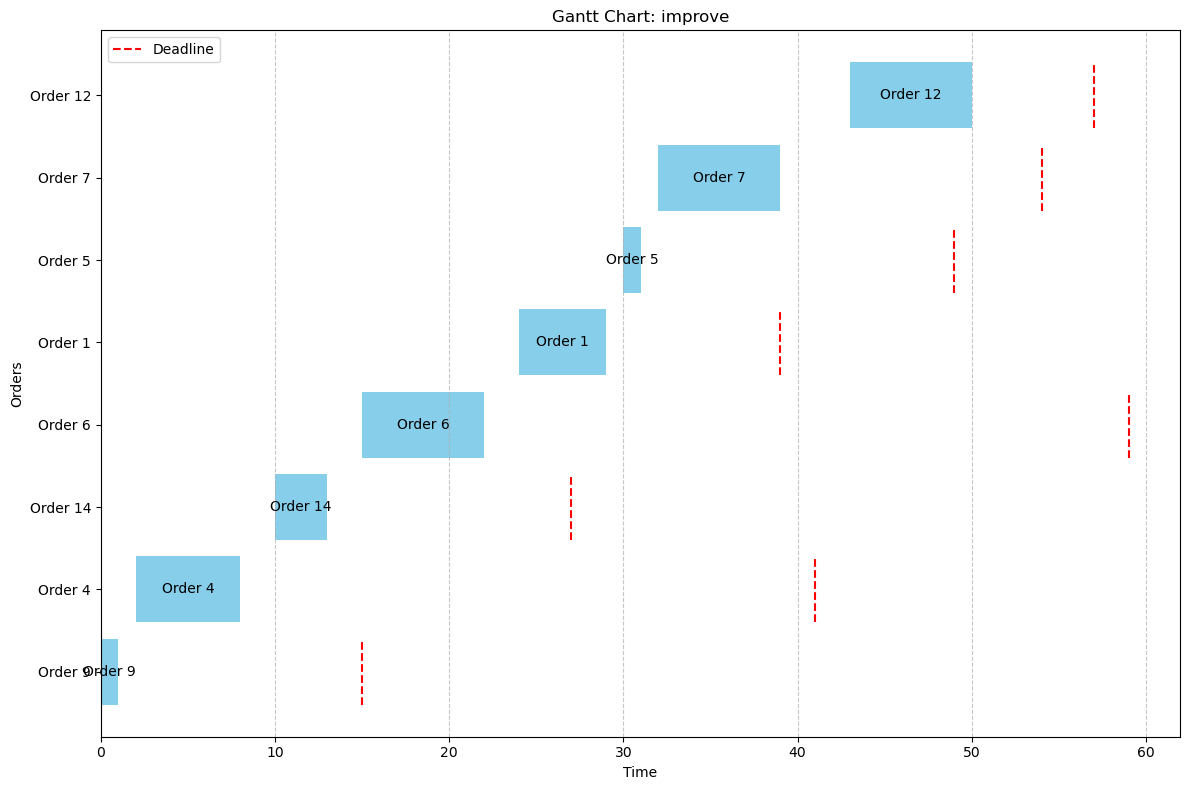

Results for OAS2.txt using improve:
Scheduled Orders: [9, 4, 14, 6, 1, 5, 7, 12]
Total Profit: 391.500002
Run Time: 0.0269 seconds
--------------------------------------------------


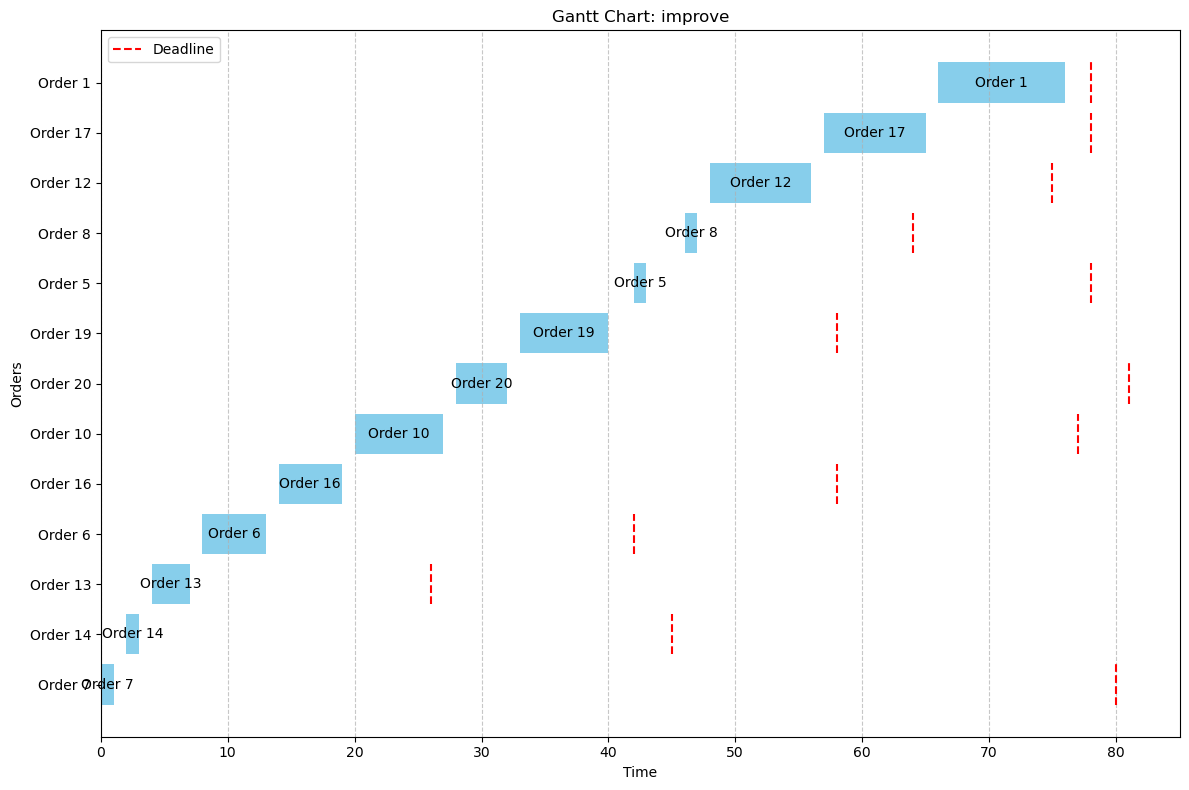

Results for OAS3.txt using improve:
Scheduled Orders: [7, 14, 13, 6, 16, 10, 20, 19, 5, 8, 12, 17, 1]
Total Profit: 872
Run Time: 0.1167 seconds
--------------------------------------------------


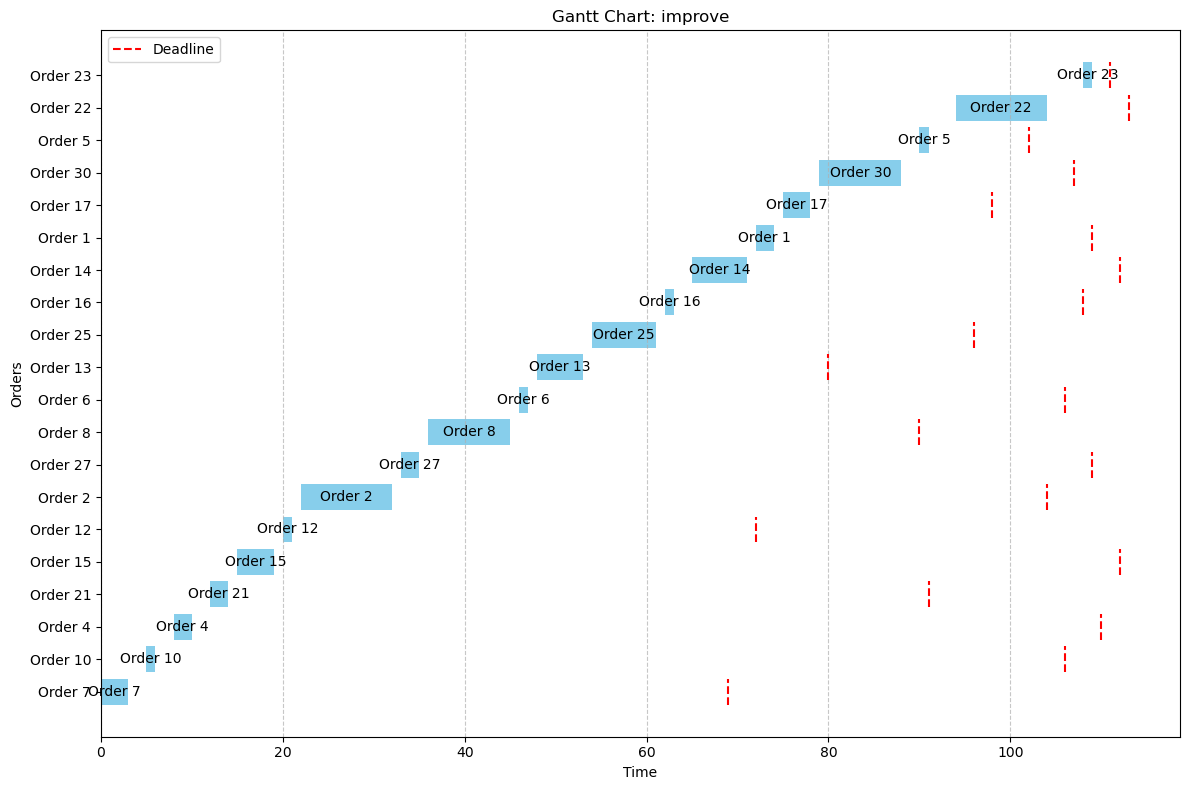

Results for OAS4.txt using improve:
Scheduled Orders: [7, 10, 4, 21, 15, 12, 2, 27, 8, 6, 13, 25, 16, 14, 1, 17, 30, 5, 22, 23]
Total Profit: 875
Run Time: 0.3591 seconds
--------------------------------------------------


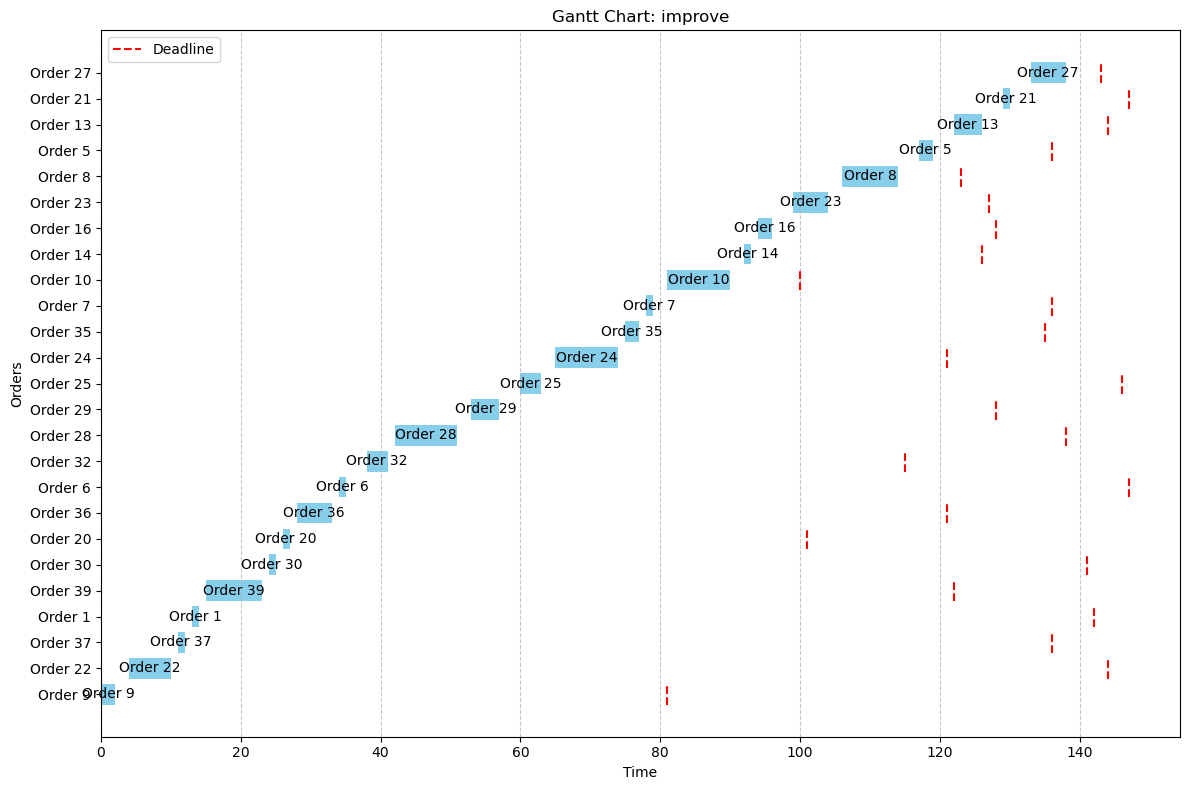

Results for OAS5.txt using improve:
Scheduled Orders: [9, 22, 37, 1, 39, 30, 20, 36, 6, 32, 28, 29, 25, 24, 35, 7, 10, 14, 16, 23, 8, 5, 13, 21, 27]
Total Profit: 1202
Run Time: 1.0232 seconds
--------------------------------------------------


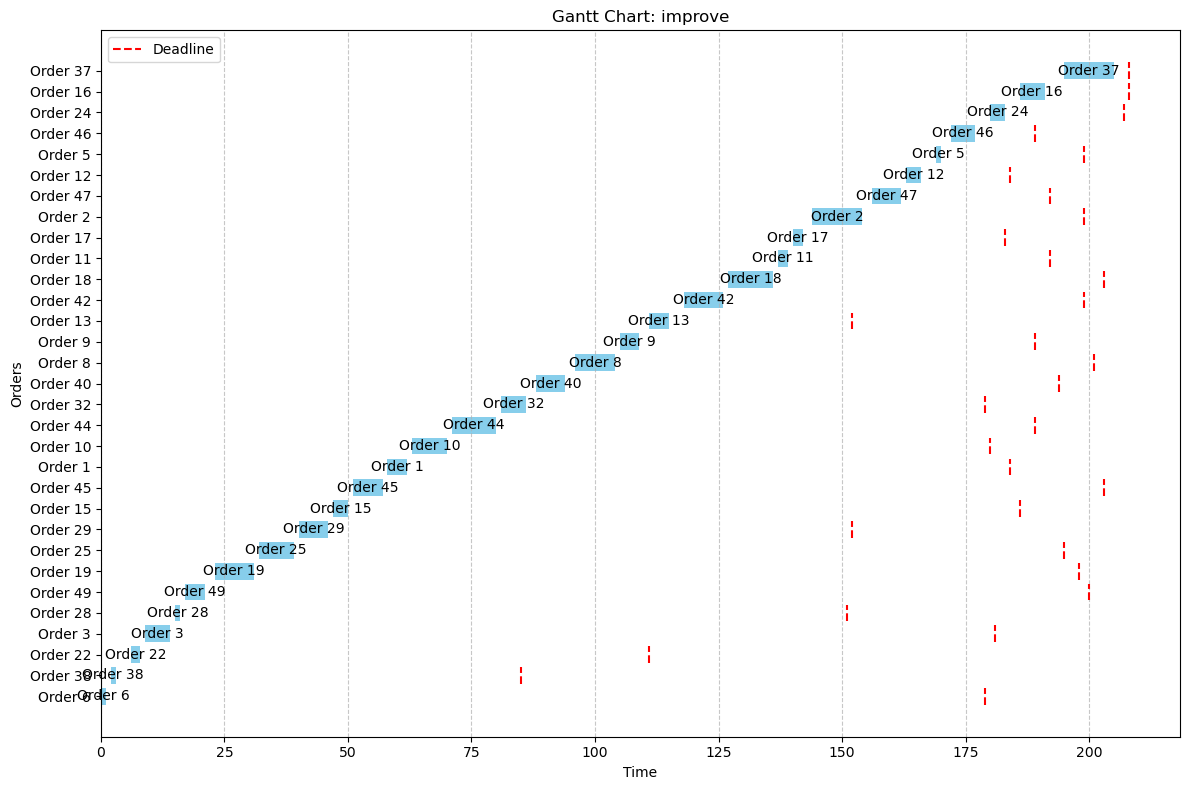

Results for OAS6.txt using improve:
Scheduled Orders: [6, 38, 22, 3, 28, 49, 19, 25, 29, 15, 45, 1, 10, 44, 32, 40, 8, 9, 13, 42, 18, 11, 17, 2, 47, 12, 5, 46, 24, 16, 37]
Total Profit: 1660
Run Time: 2.5562 seconds
--------------------------------------------------


In [19]:
for file_name in file_names:
    Run_and_visualize_improved(file_name, improve, "improve")

### 6.heuristic runtimes

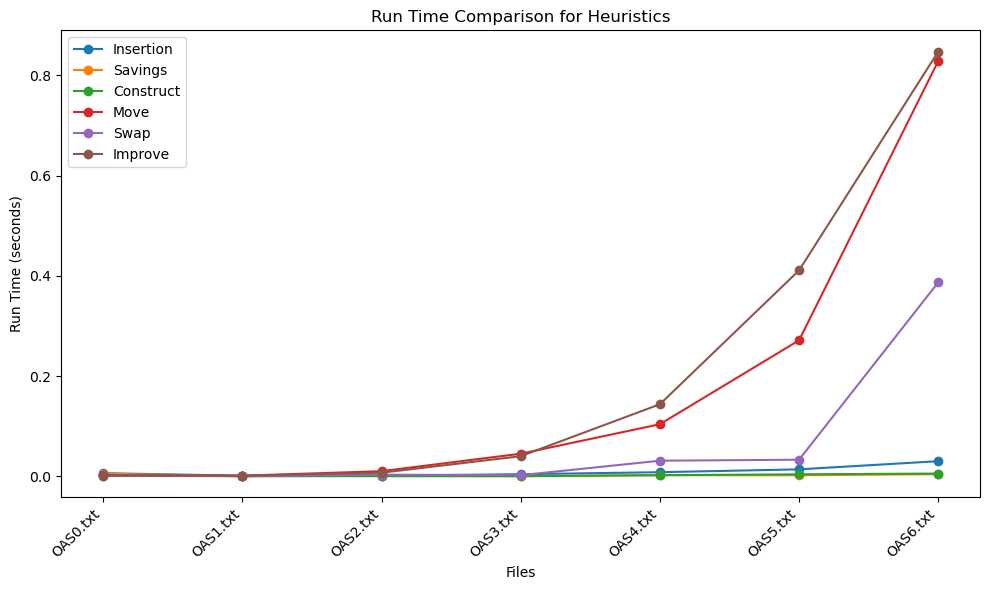

In [22]:
import matplotlib.pyplot as plt
import time
    
heuristics = ['Insertion', 'Savings', 'Construct', 'Move', 'Swap', 'Improve']
run_times = {heuristic: [] for heuristic in heuristics}

for file_name in file_names:
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)

    # Insertion
    start_time = time.time()
    scheduled_orders, total_profit = insertion(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    end_time = time.time()
    run_times['Insertion'].append(end_time - start_time)

    # Savings
    start_time = time.time()
    scheduled_orders, total_profit = savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    end_time = time.time()
    run_times['Savings'].append(end_time - start_time)

    # Construct
    start_time = time.time()
    initial_solution, _ = construct(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    end_time = time.time()
    run_times['Construct'].append(end_time - start_time)

    # Move
    start_time = time.time()
    scheduled_orders, improved_profit = move(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
    end_time = time.time()
    run_times['Move'].append(end_time - start_time)

    # Swap
    start_time = time.time()
    scheduled_orders, improved_profit = swap(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
    end_time = time.time()
    run_times['Swap'].append(end_time - start_time)

    # Improve
    start_time = time.time()
    improved_solution, optimal_profit = improve(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders, max_iterations=1)
    end_time = time.time()
    run_times['Improve'].append(end_time - start_time)

plt.figure(figsize=(10, 6))

for heuristic in heuristics:
    plt.plot(file_names, run_times[heuristic], marker='o', label=heuristic)

plt.xlabel('Files')
plt.ylabel('Run Time (seconds)')
plt.title('Run Time Comparison for Heuristics')

plt.legend()

plt.xticks(rotation=45, ha="right") 
plt.tight_layout()
plt.show()


### 7.Profit Comparison

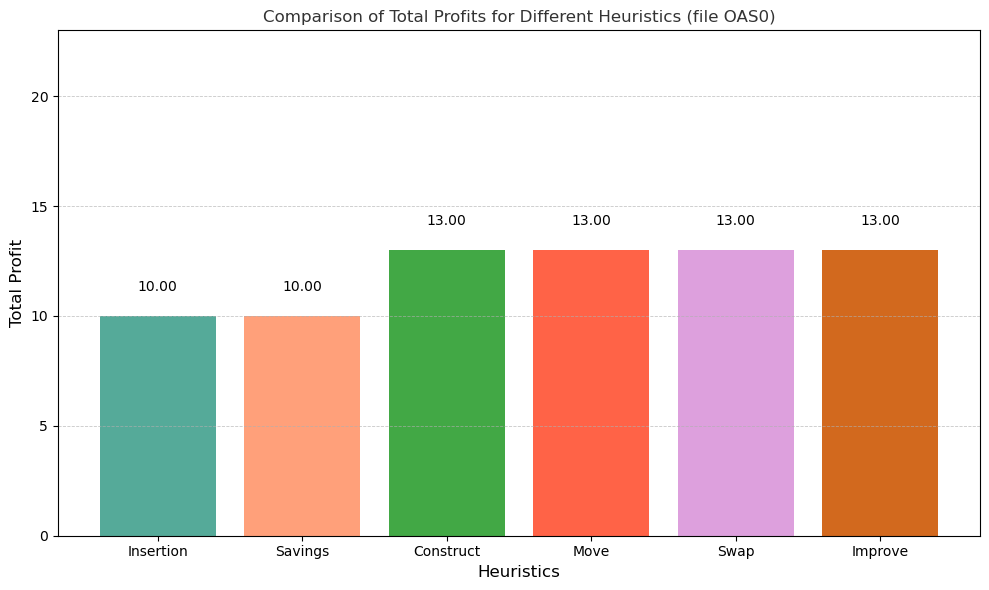

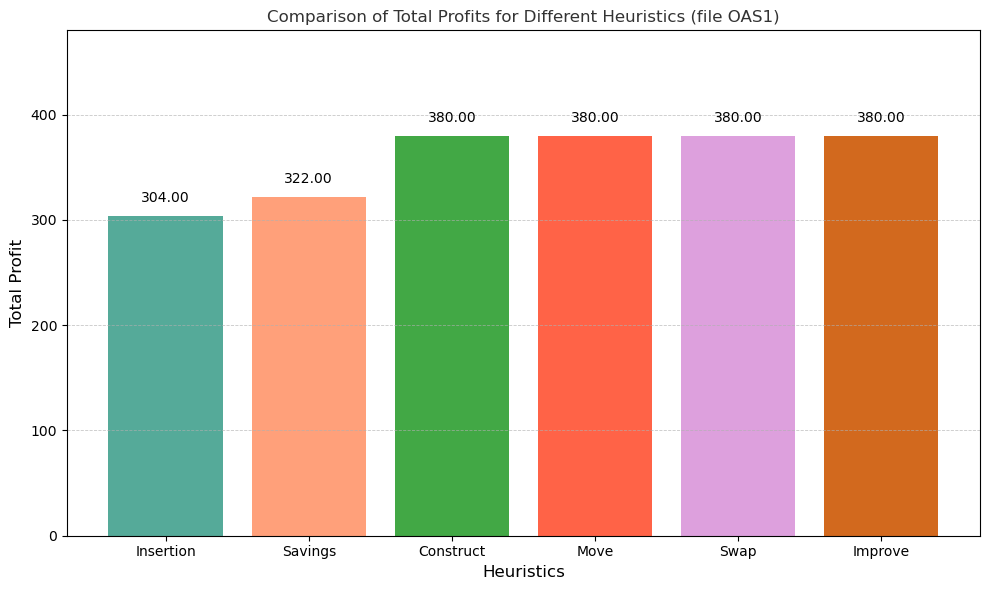

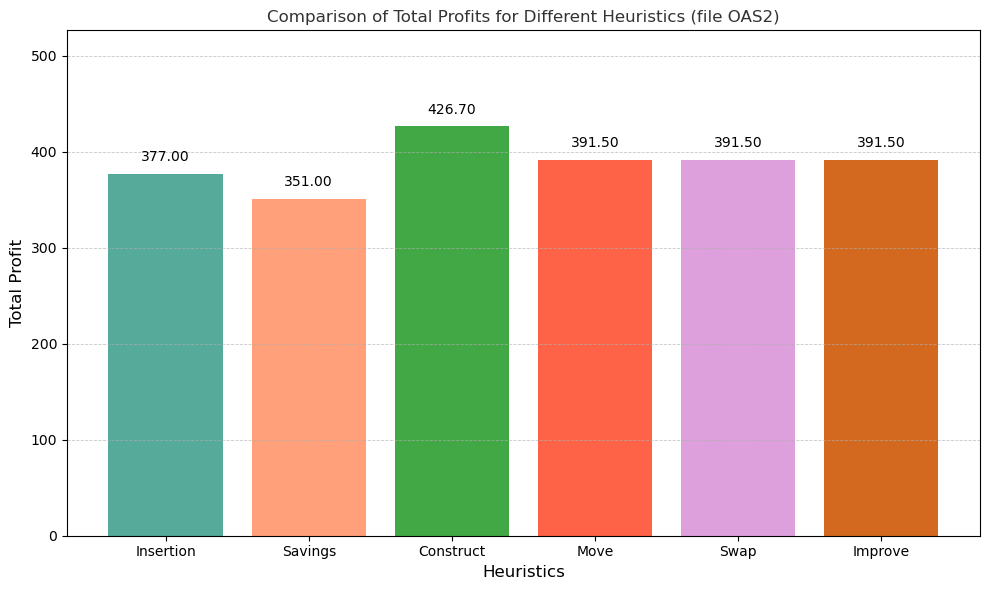

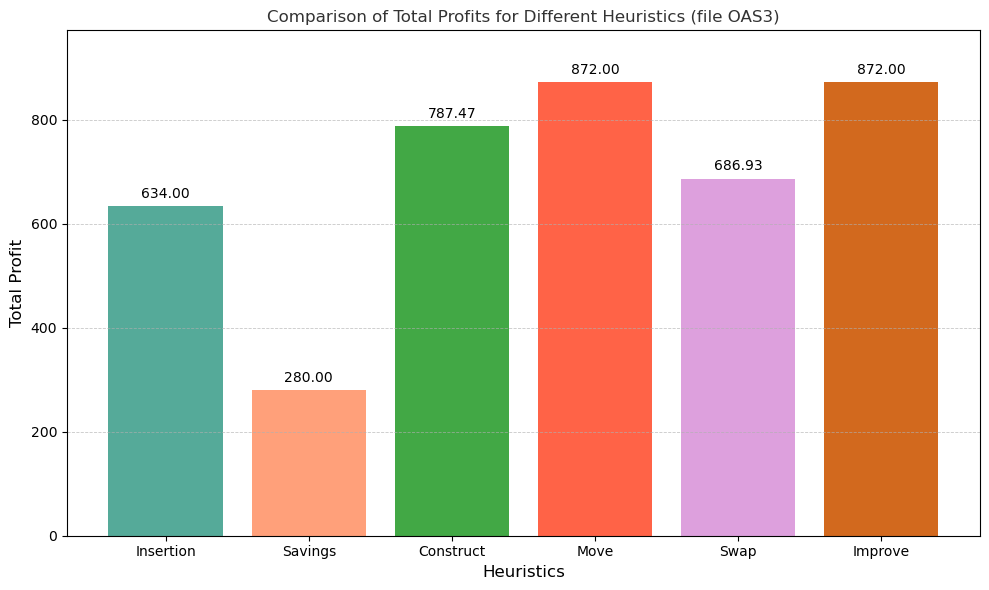

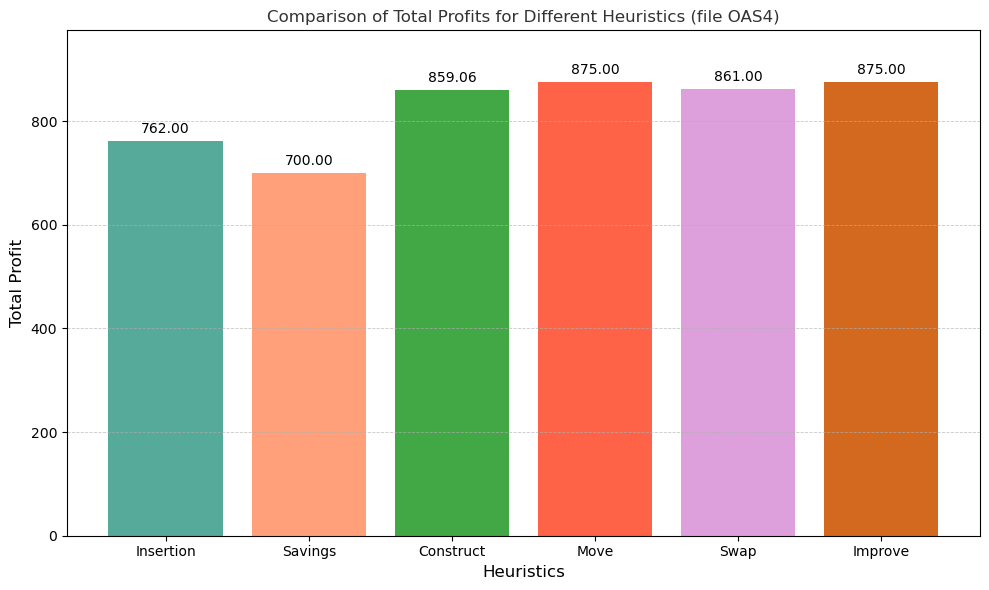

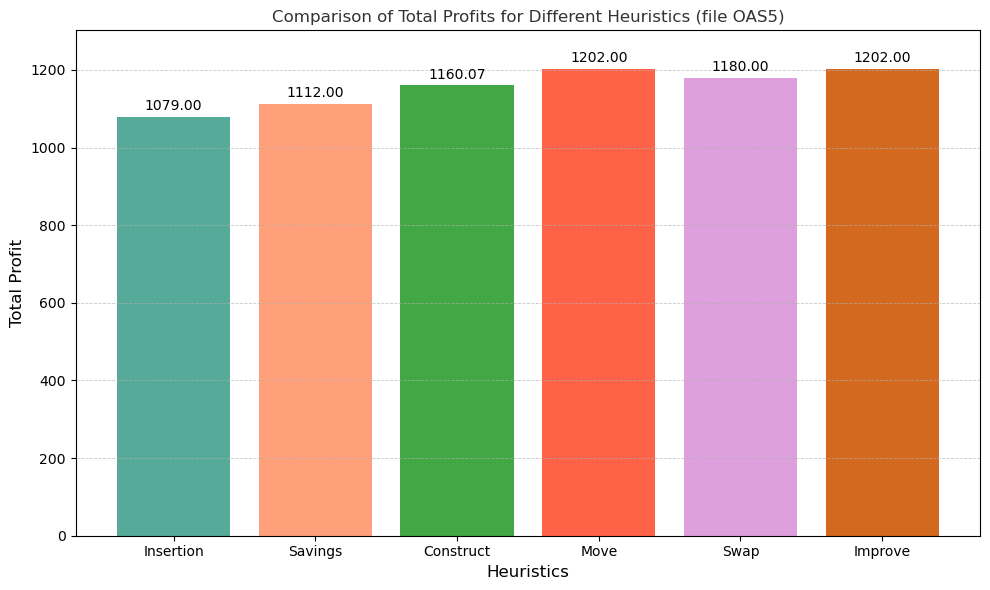

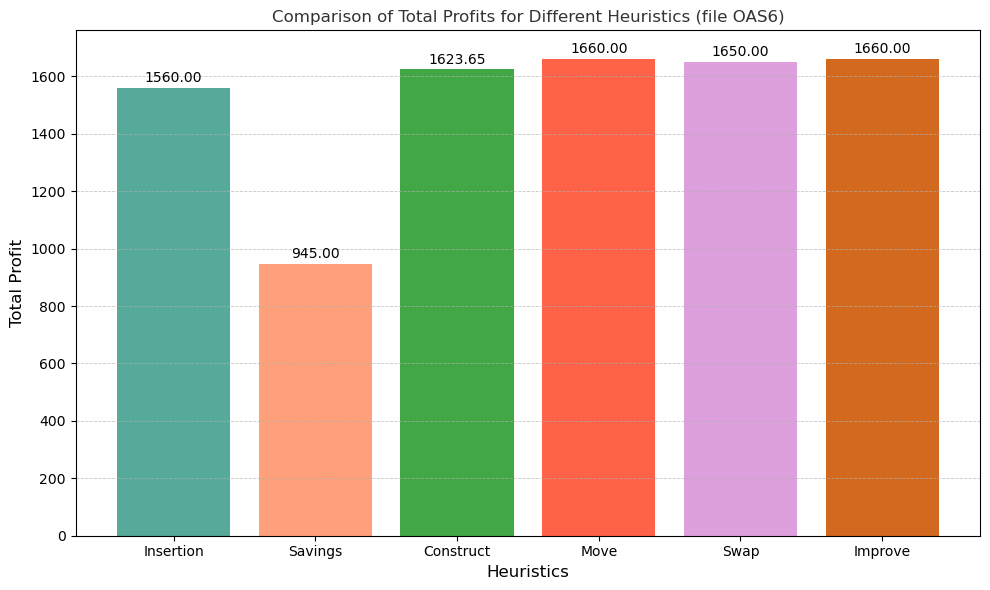

In [21]:
heuristics = ["Insertion", "Savings", "Construct", "Move", "Swap", "Improve"]
total_profits_list = [
    np.array([10, 10, 13, 13, 13, 13], dtype=np.float32),
    np.array([304, 322, 380, 380, 380, 380], dtype=np.float32),
    np.array([377, 351, 426.703297, 391.500002, 391.500002, 391.500002], dtype=np.float32),
    np.array([634, 280, 787.466679, 872, 686.933348, 872], dtype=np.float32),
    np.array([762, 700, 859.055555, 875, 861, 875], dtype=np.float32),
    np.array([1079, 1112, 1160.074094, 1202, 1180, 1202], dtype=np.float32),
    np.array([1560, 945, 1623.649228, 1660, 1650, 1660], dtype=np.float32)
]

colors = ["#5A9", "#FFA07A", "#42A845", "#FF6347", "#DDA0DD", "#D2691E"]

def plot_profit_comparison(heuristics, total_profits, title):
    plt.figure(figsize=(10, 6))

    plt.bar(heuristics, total_profits, color=colors)

    plt.xlabel("Heuristics", fontsize=12)
    plt.ylabel("Total Profit", fontsize=12)
    plt.title(title, fontsize=12, color='#333333')
    plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.7)

    max_profit = max(total_profits)
    plt.ylim(0, max_profit + 100) 

    # Set unique y-axis limit for file 0
    if title == "Comparison of Total Profits for Different Heuristics (file OAS0)":
        plt.ylim(0, max_profit + 10) 

    for i, profit in enumerate(total_profits):
        if title == "Comparison of Total Profits for Different Heuristics (file OAS0)":
            plt.text(i, profit + 1, f"{profit:.2f}", ha="center", va="bottom", fontsize=10)
        else:
            plt.text(i, profit + 10, f"{profit:.2f}", ha="center", va="bottom", fontsize=10)

    plt.tight_layout()

    plt.show()

titles = [
    "Comparison of Total Profits for Different Heuristics (file OAS0)",
    "Comparison of Total Profits for Different Heuristics (file OAS1)",
    "Comparison of Total Profits for Different Heuristics (file OAS2)",
    "Comparison of Total Profits for Different Heuristics (file OAS3)",
    "Comparison of Total Profits for Different Heuristics (file OAS4)",
    "Comparison of Total Profits for Different Heuristics (file OAS5)",
    "Comparison of Total Profits for Different Heuristics (file OAS6)"
]

for i in range(7):
    plot_profit_comparison(heuristics, total_profits_list[i], titles[i])
